In [2]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

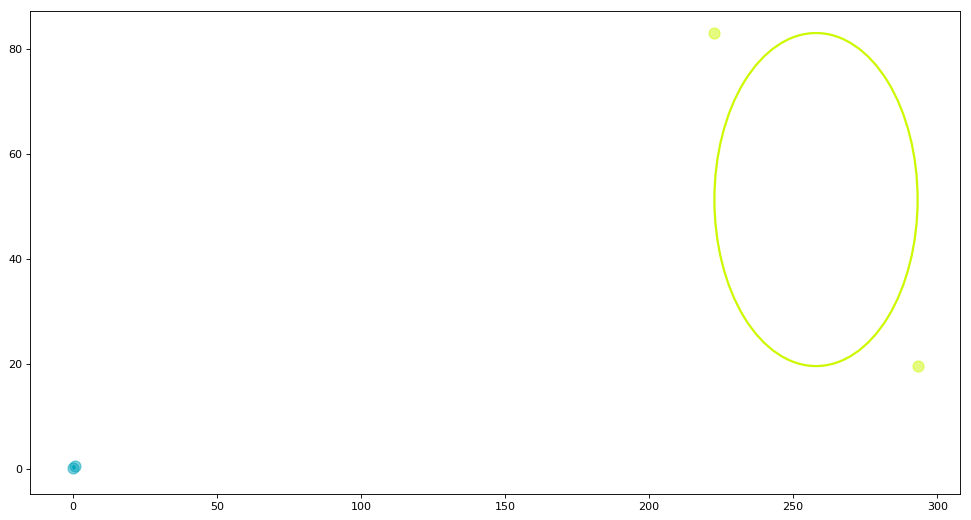

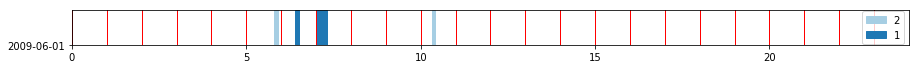

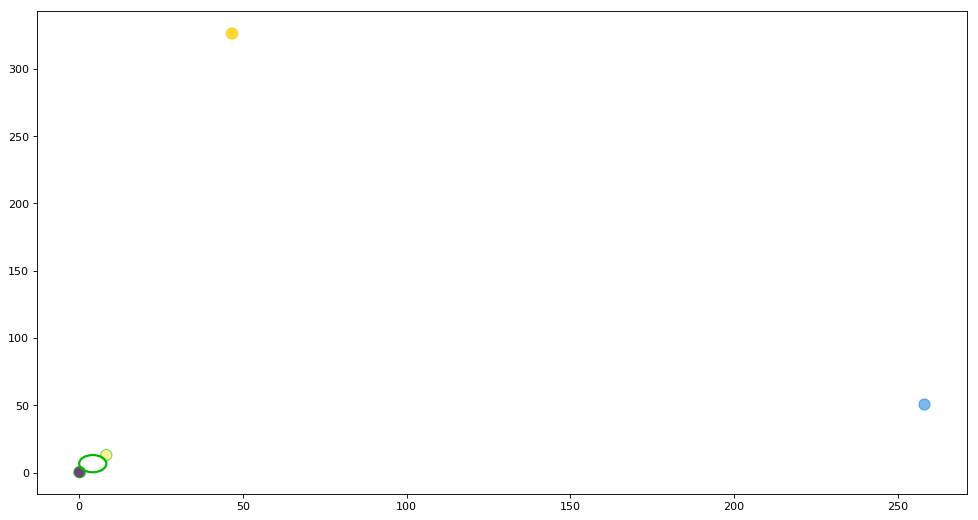

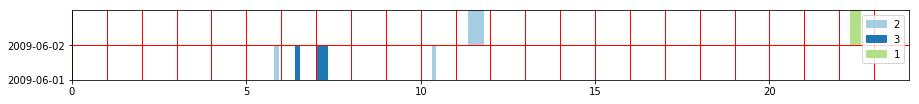

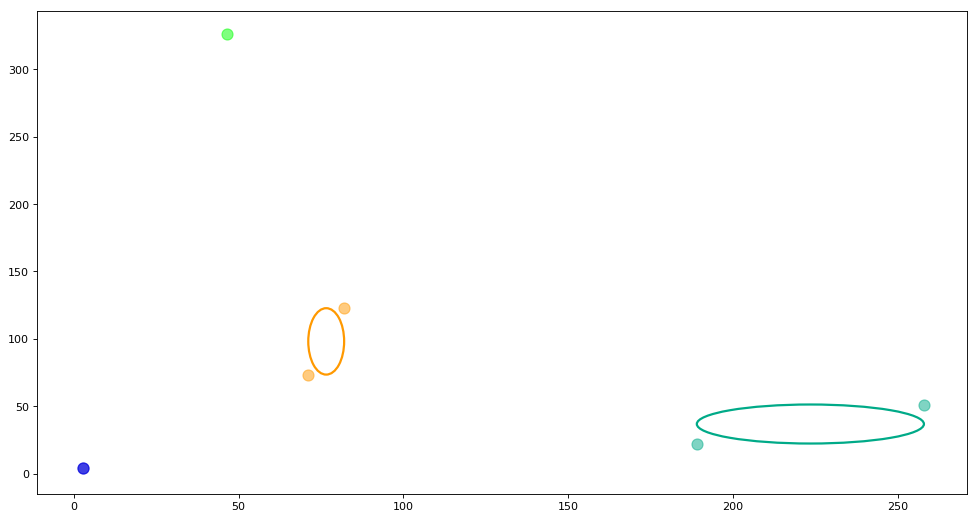

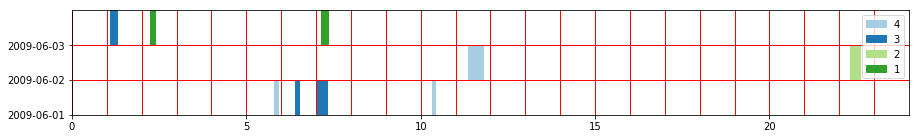

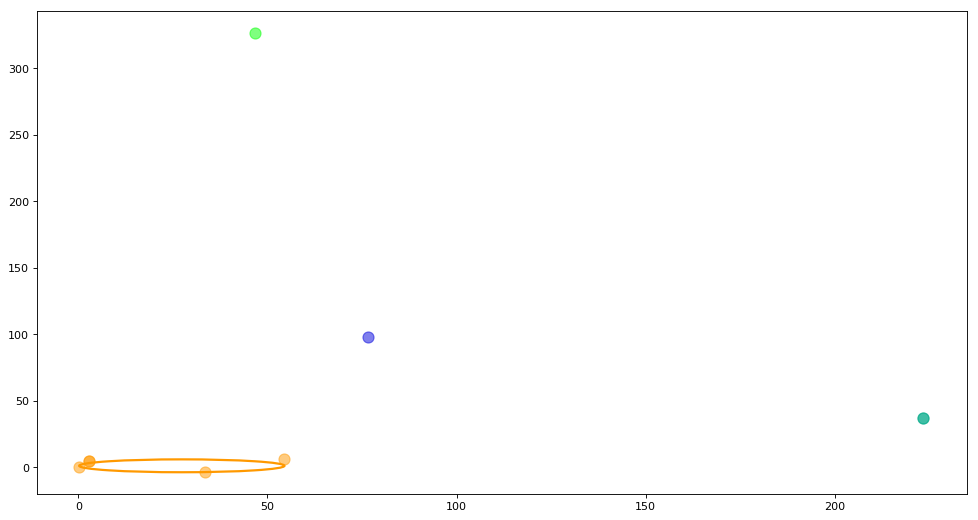

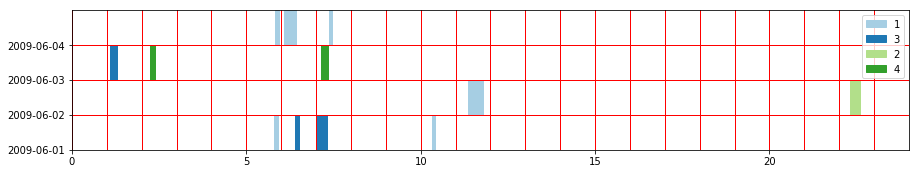

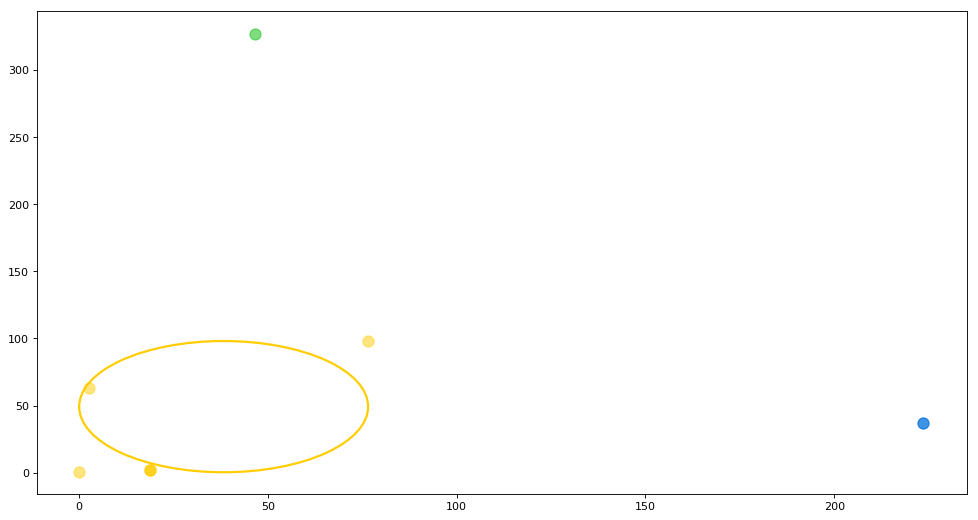

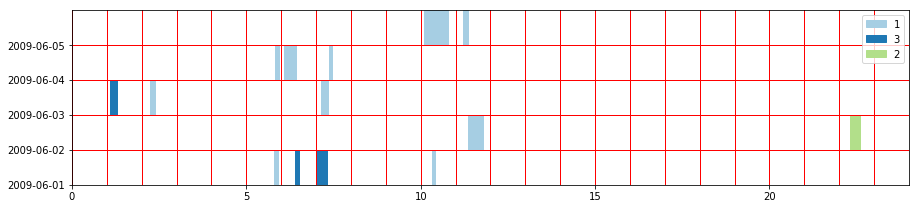

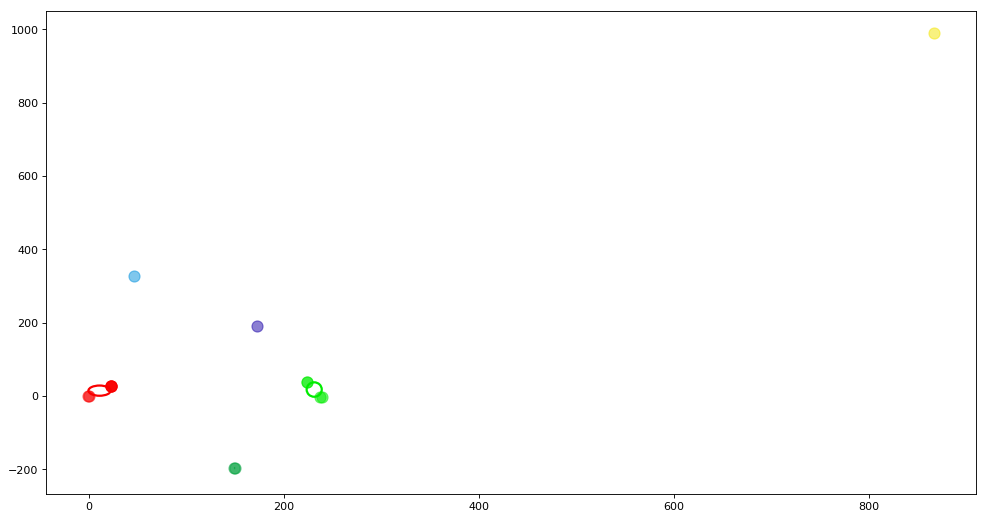

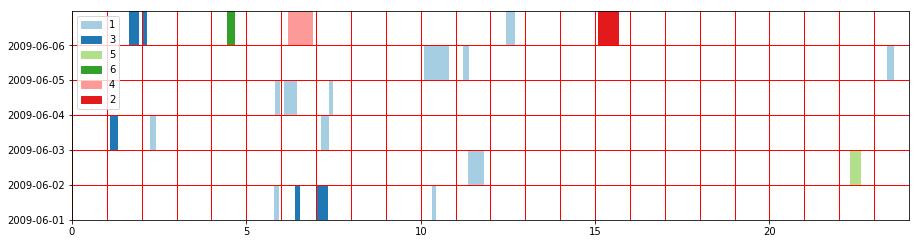

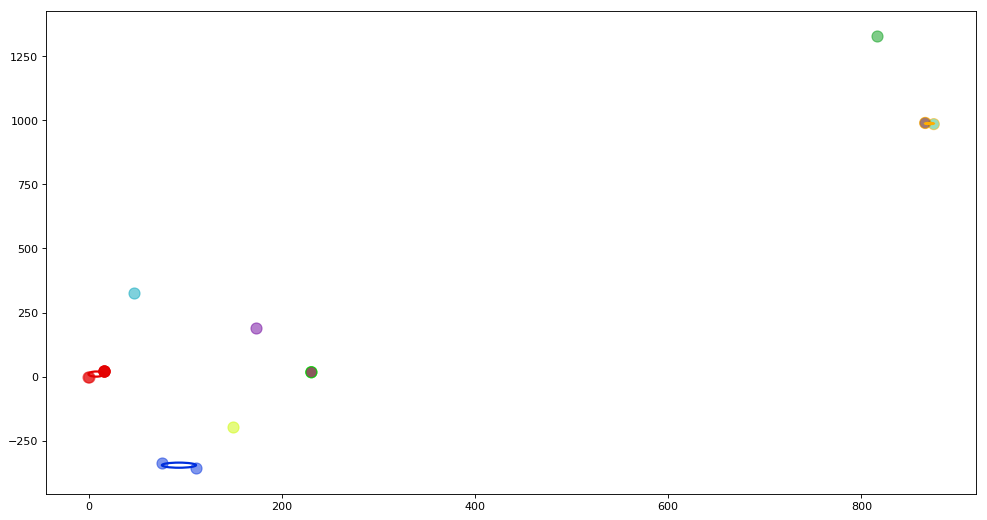

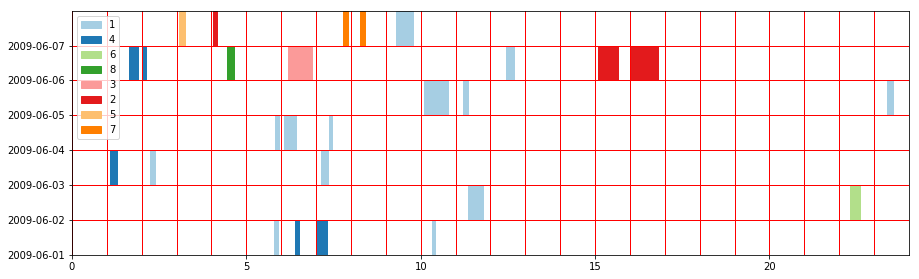

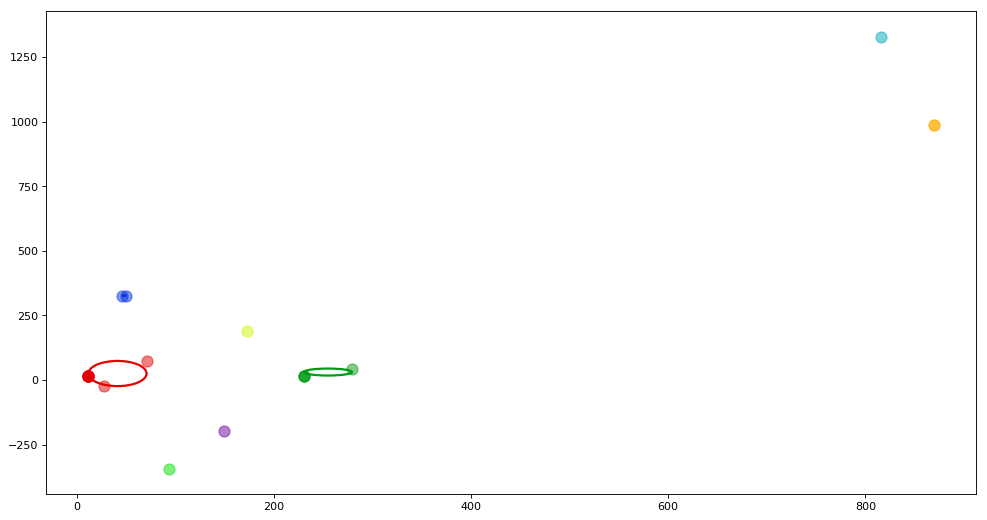

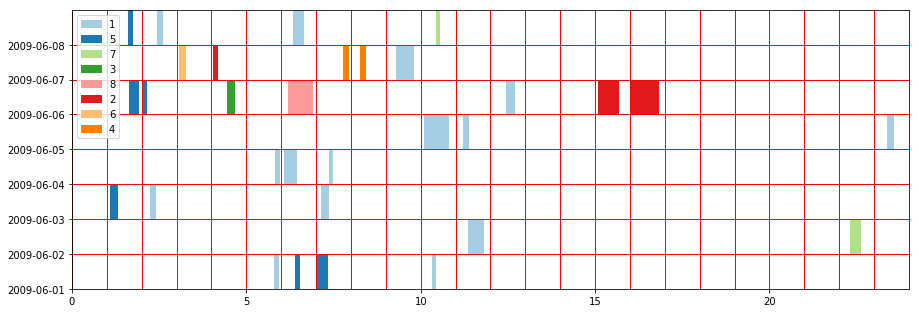

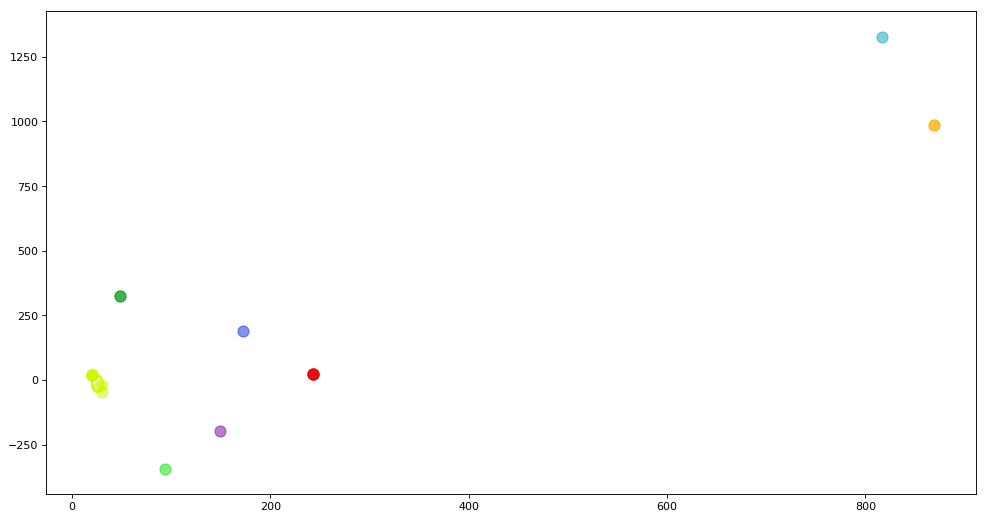

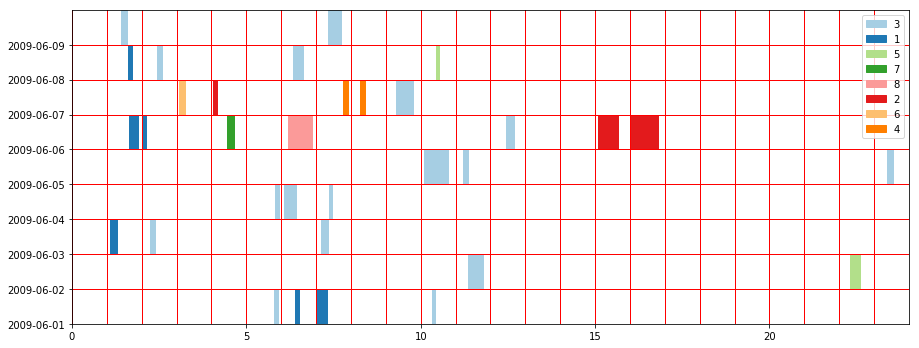

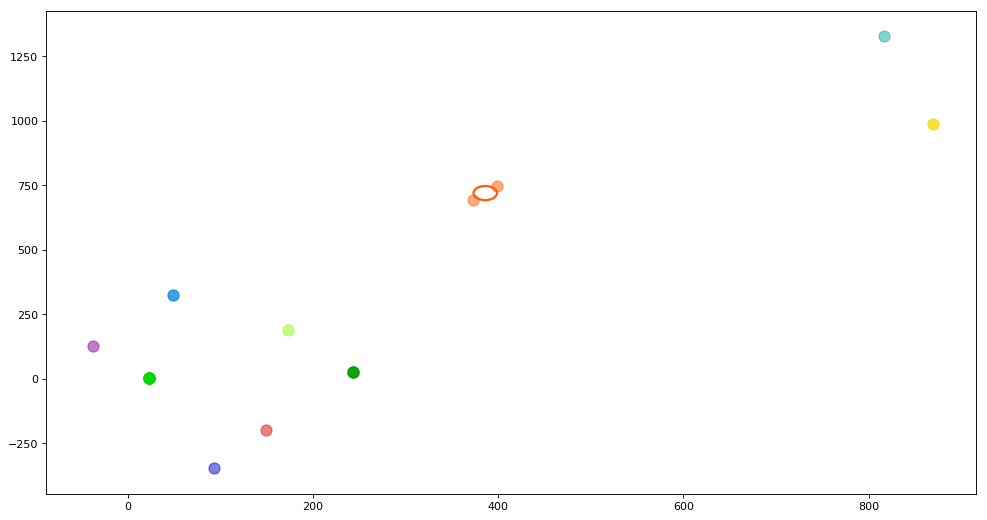

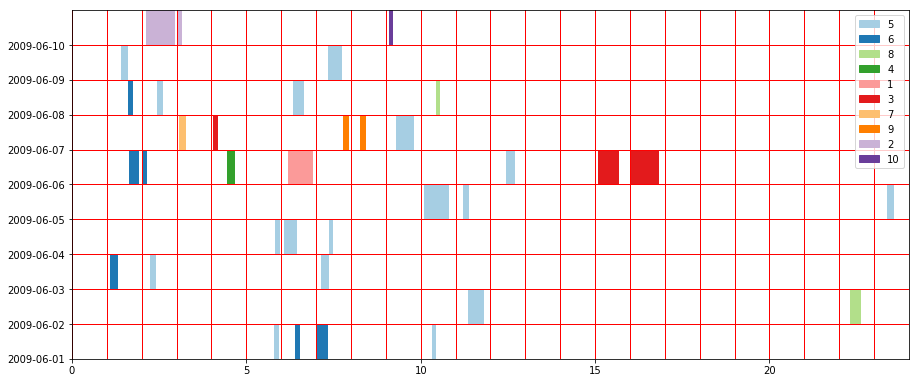

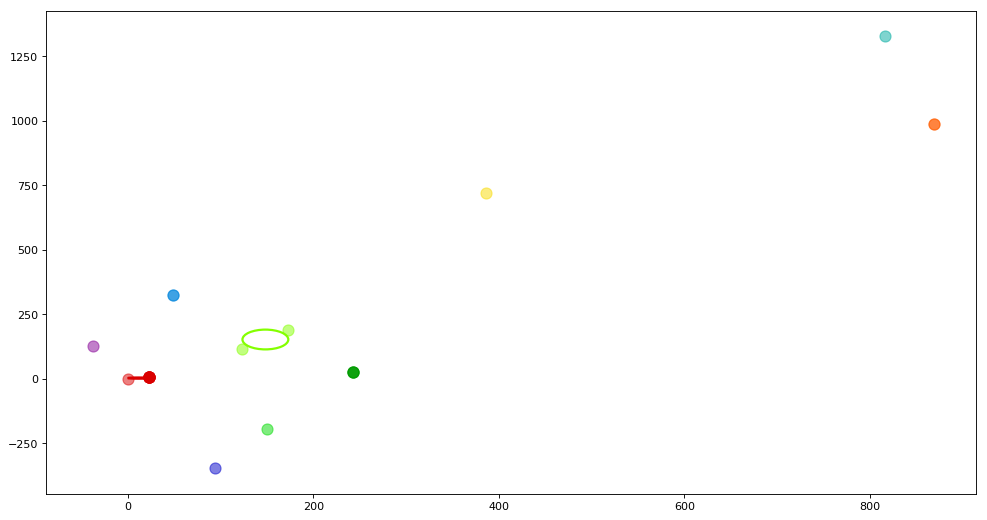

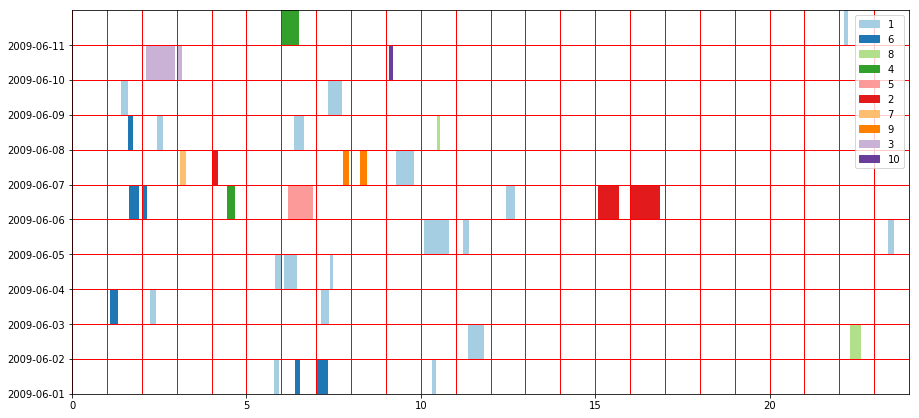

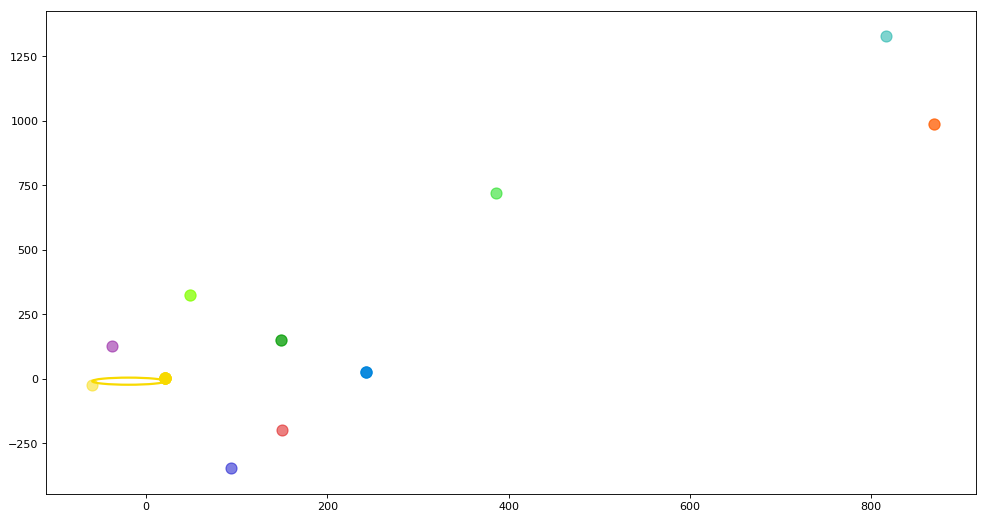

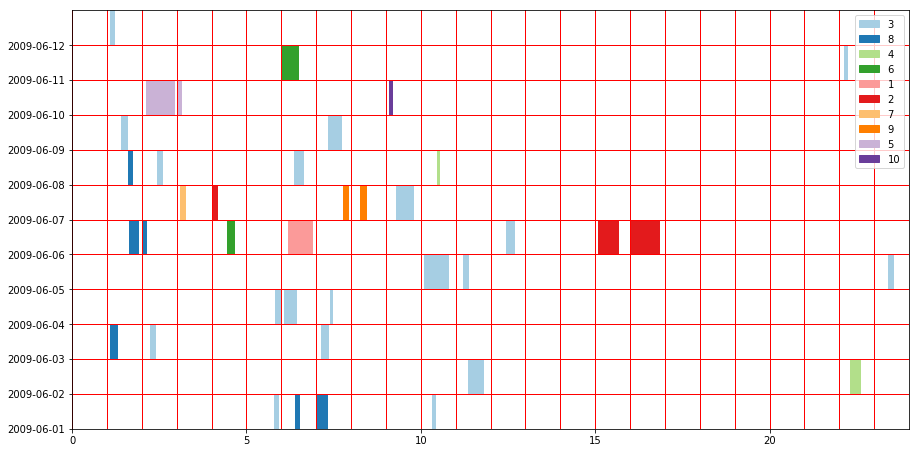

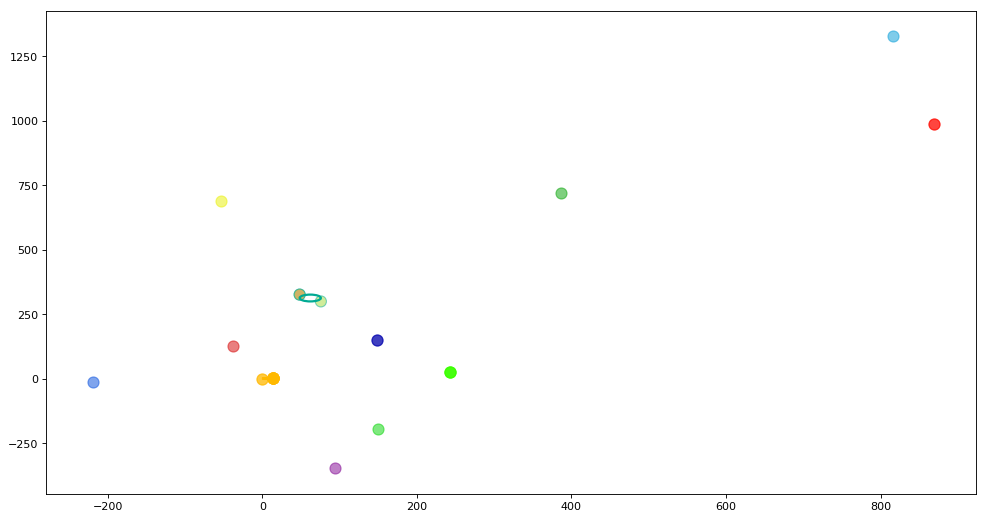

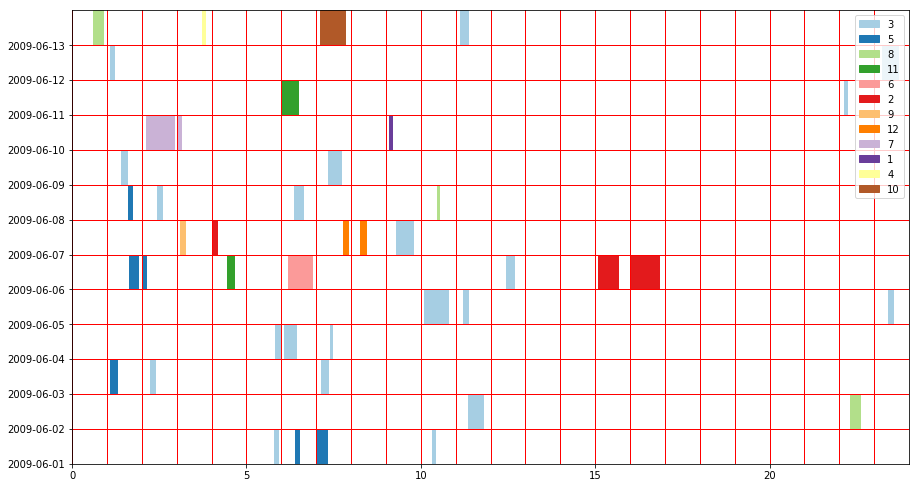

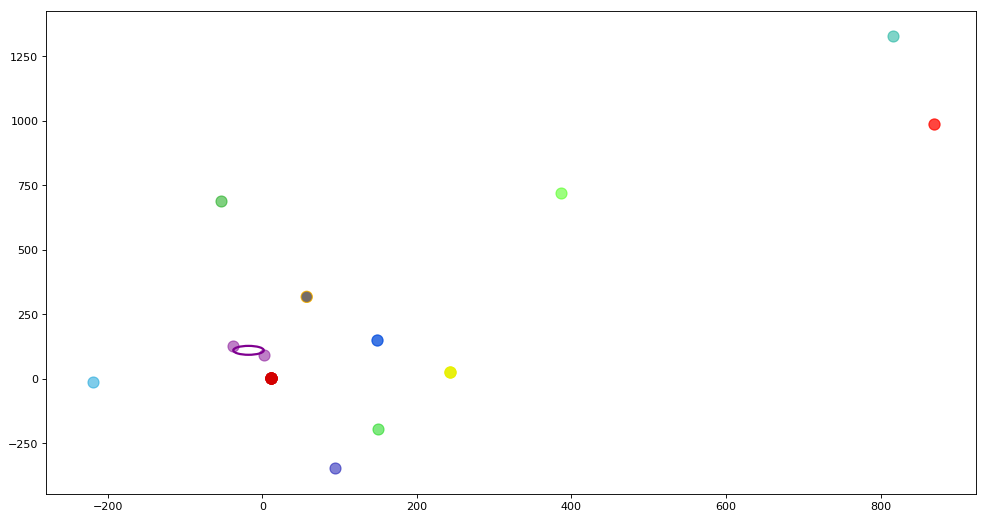

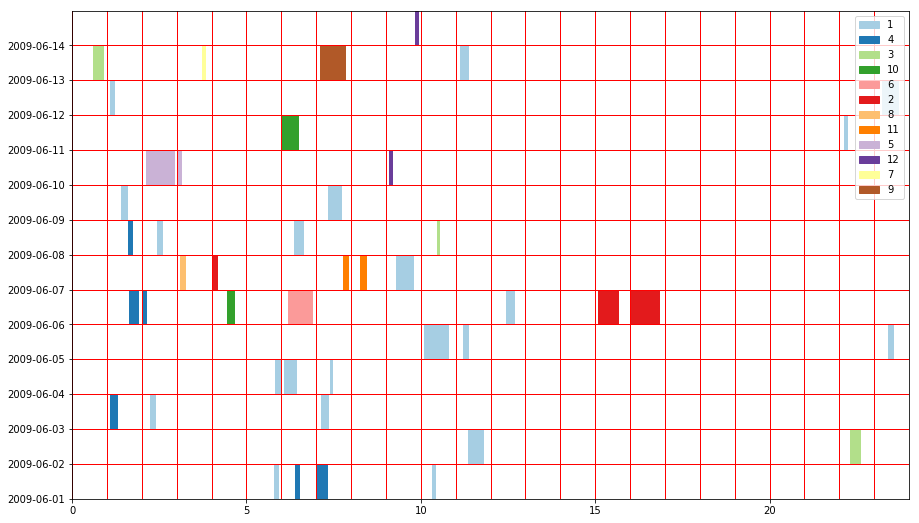

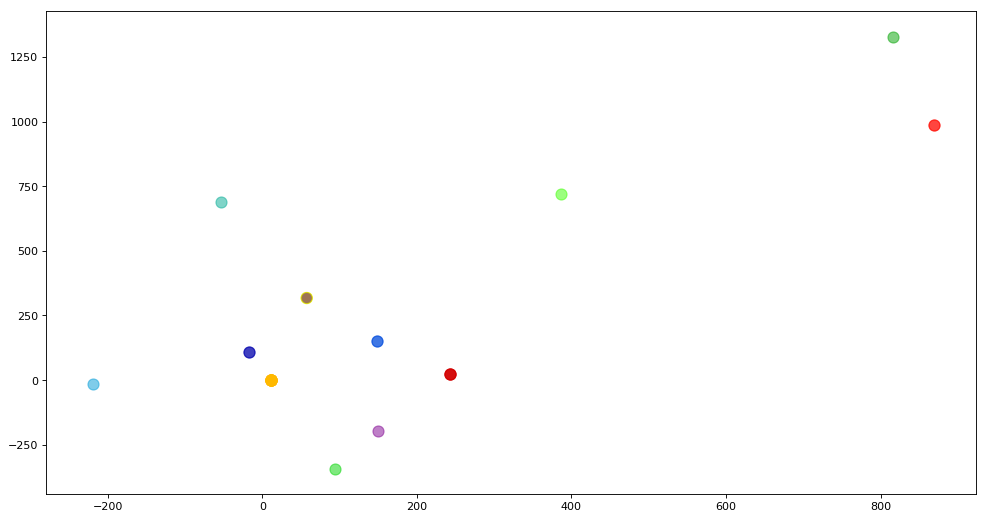

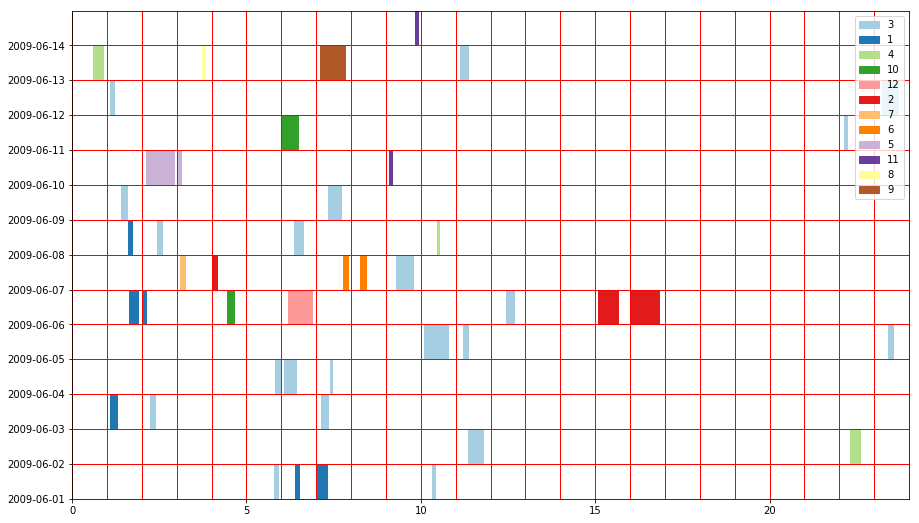

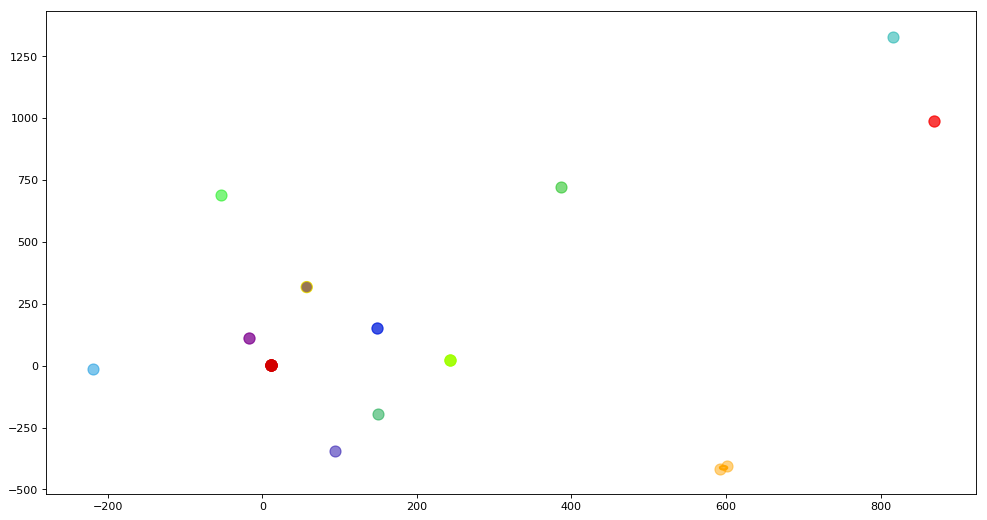

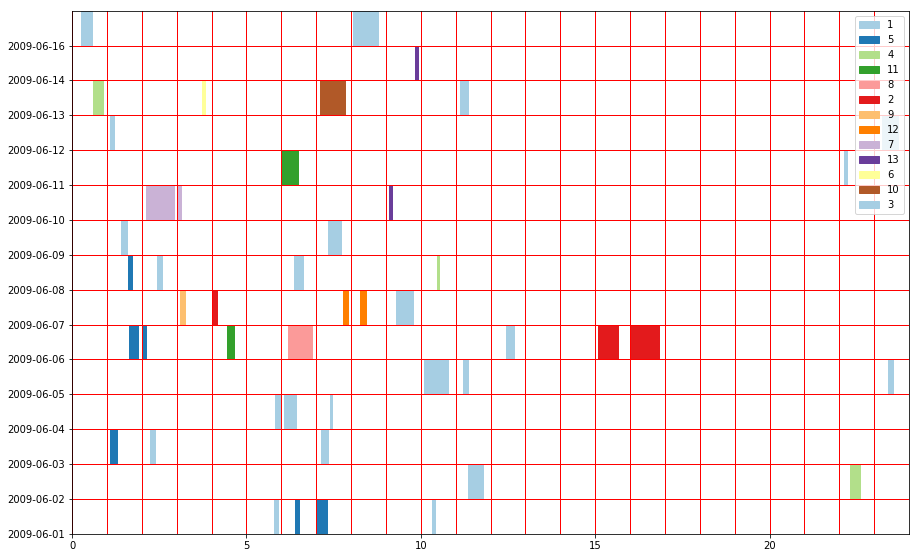

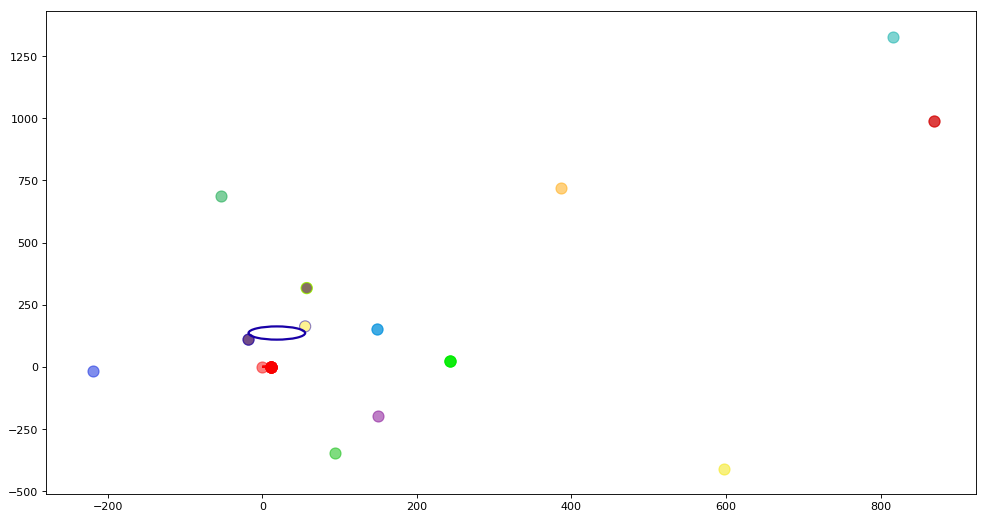

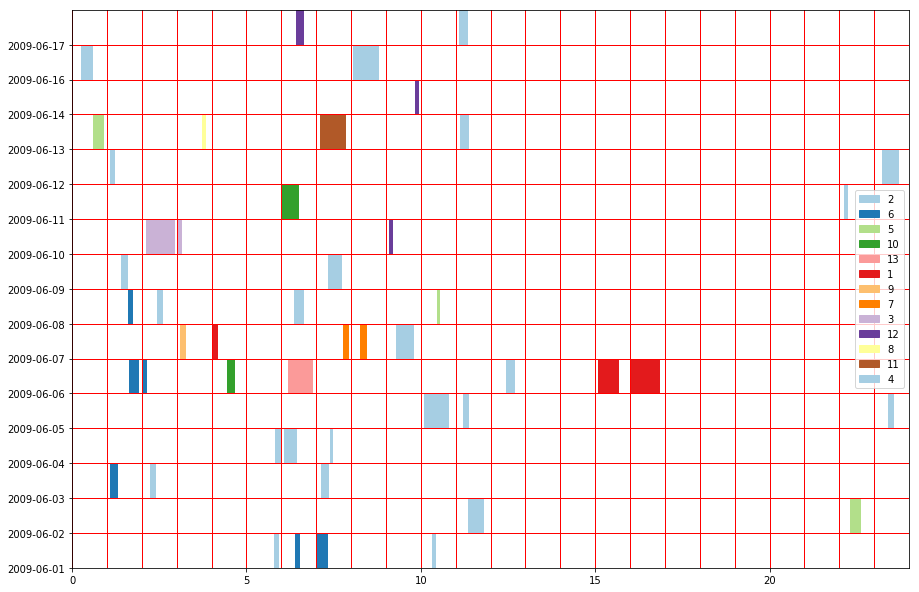

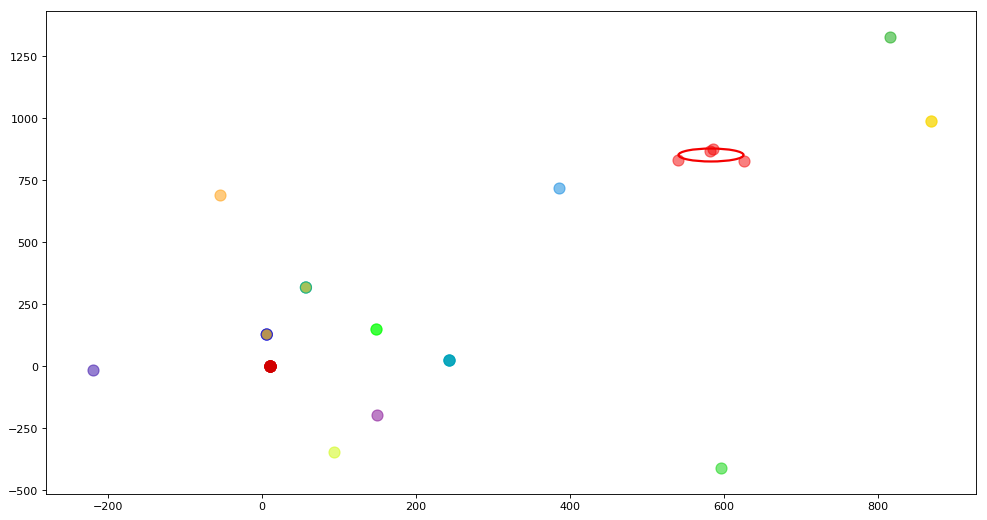

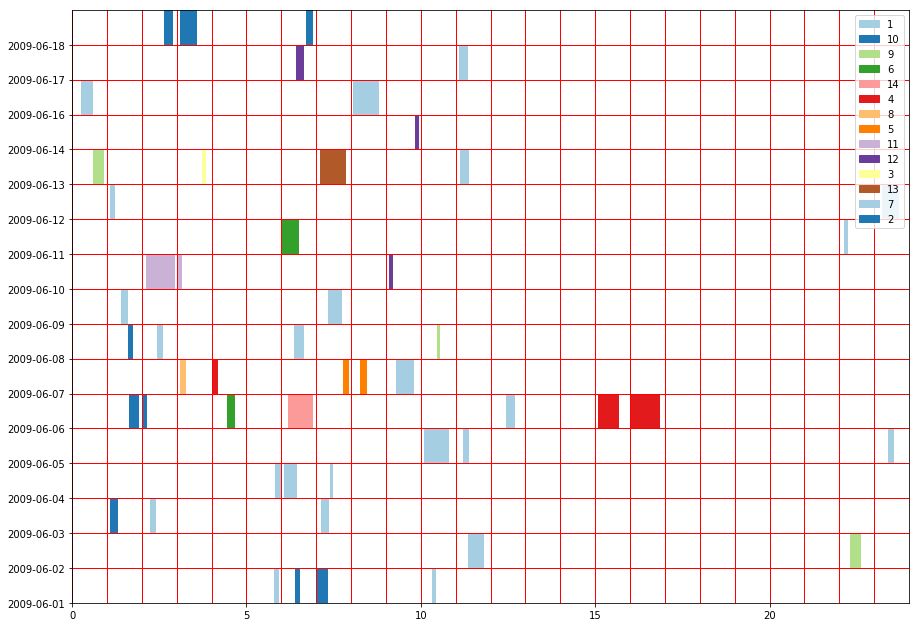

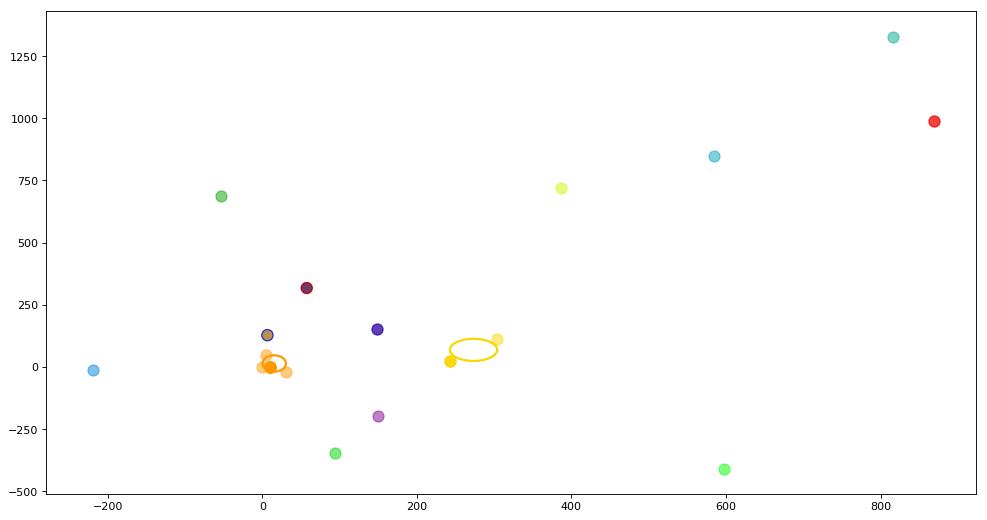

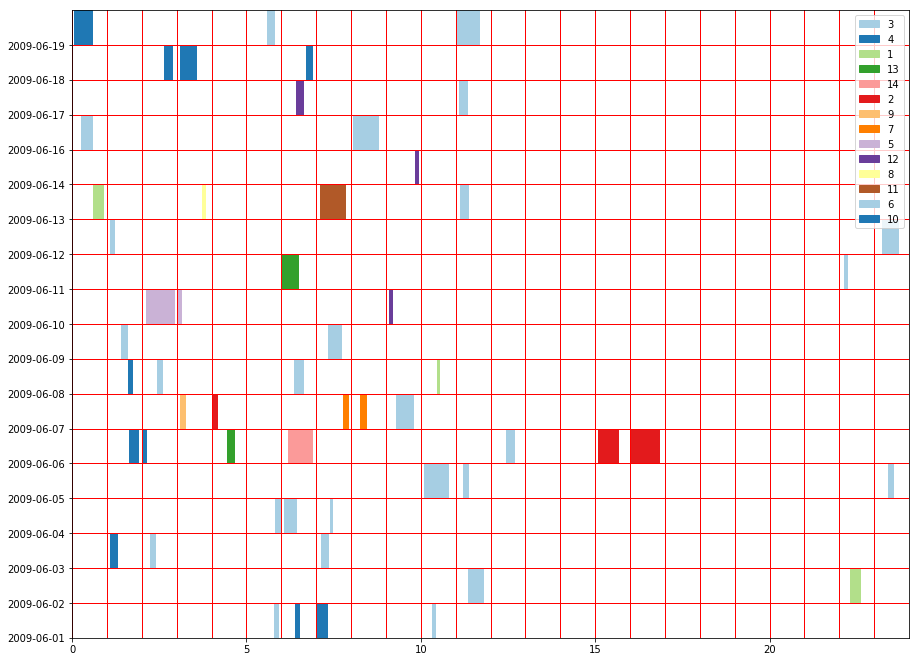

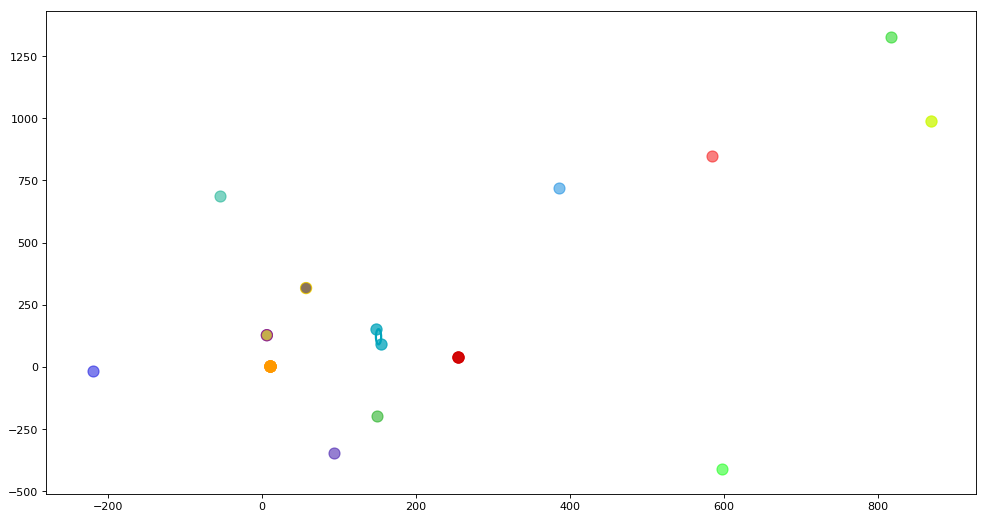

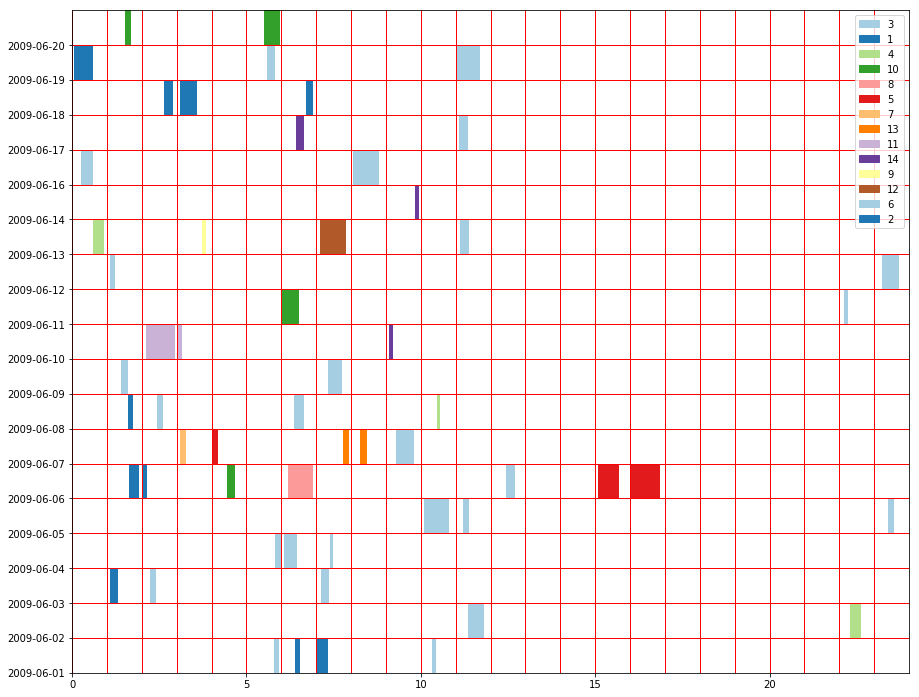

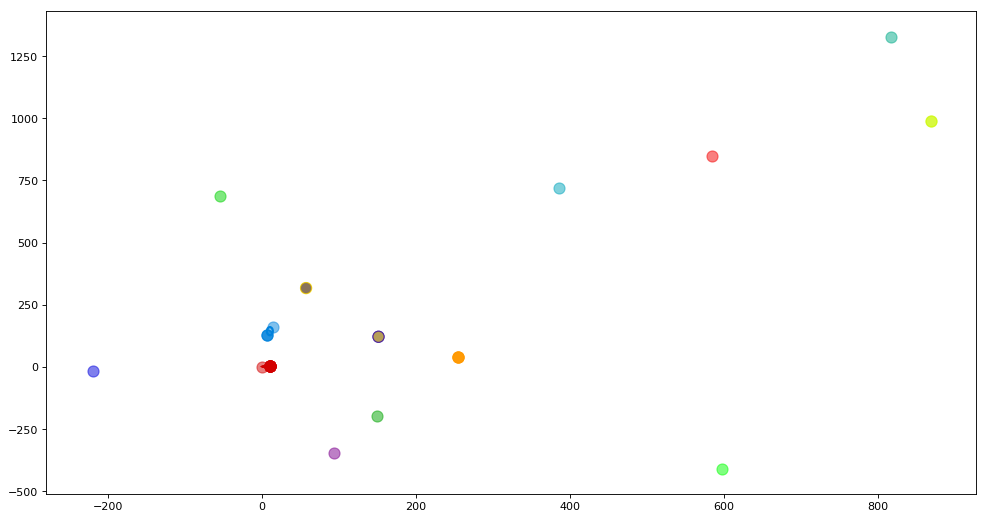

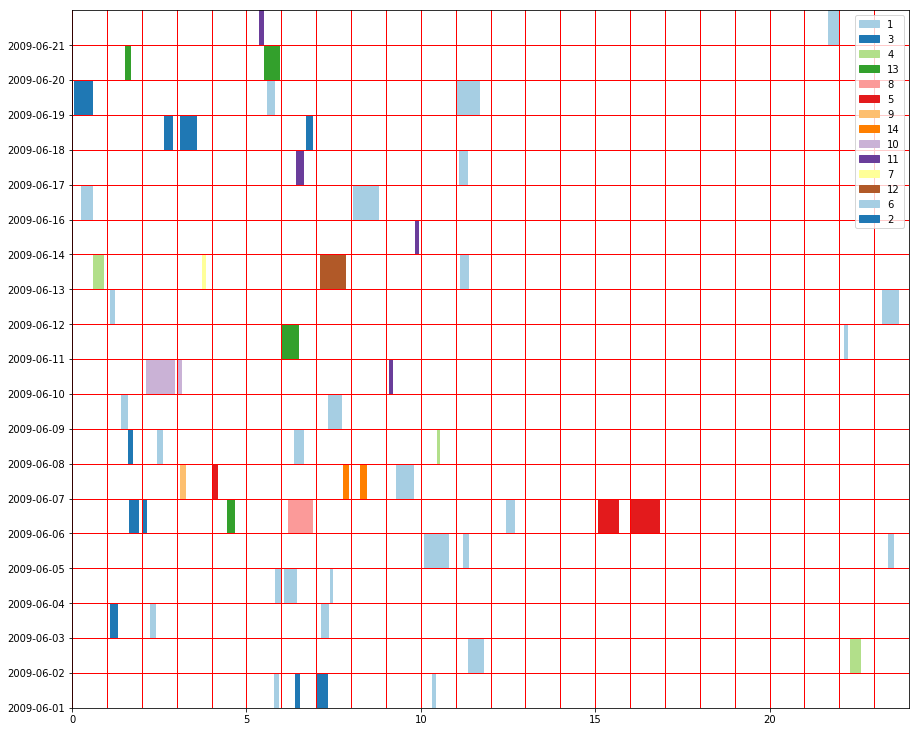

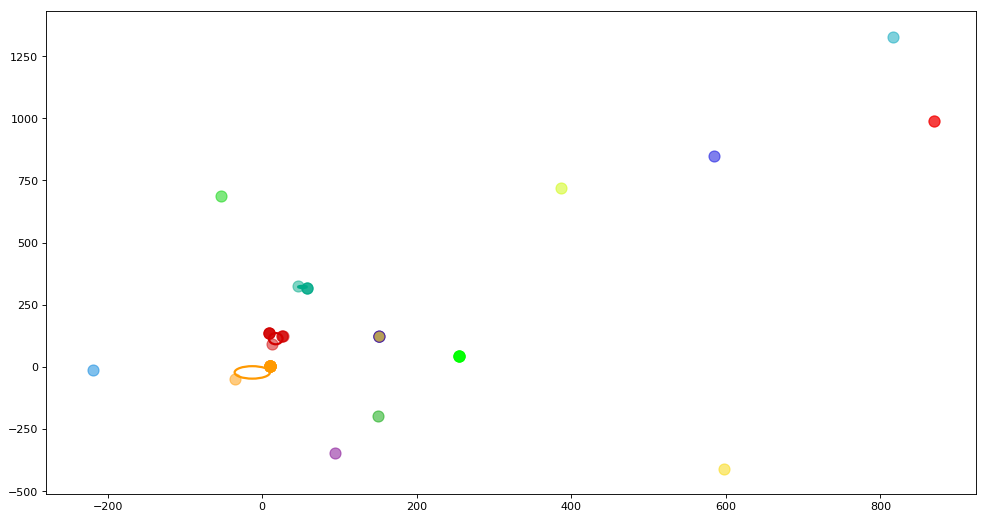

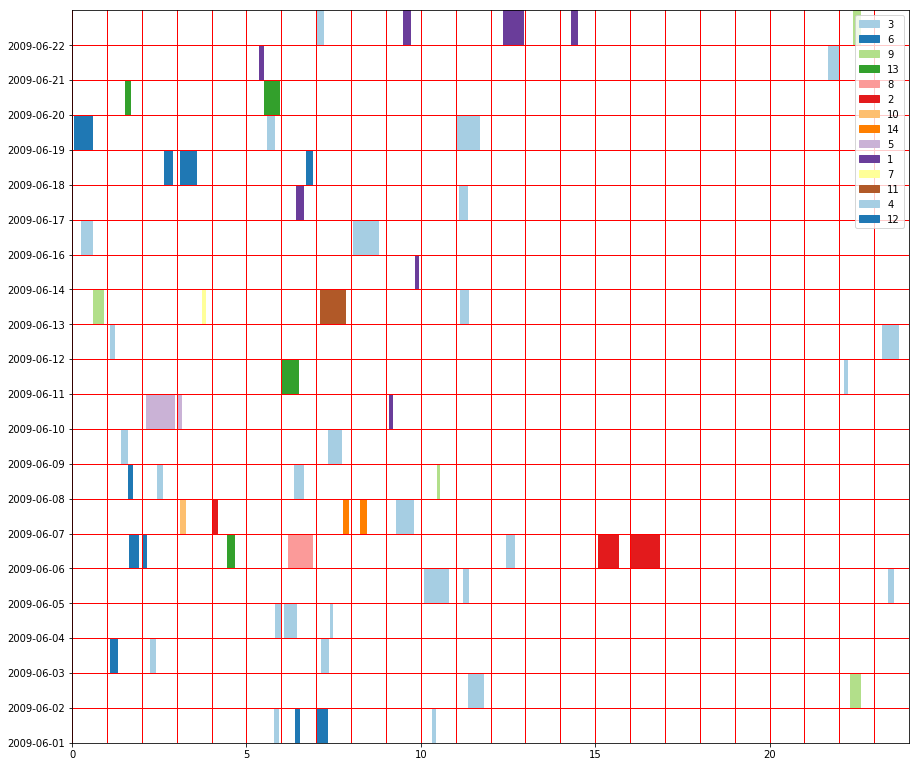

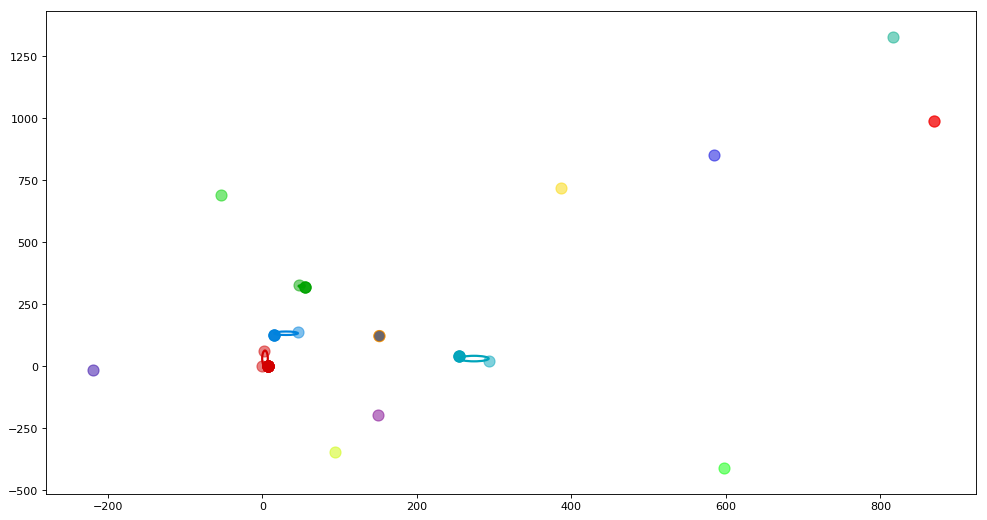

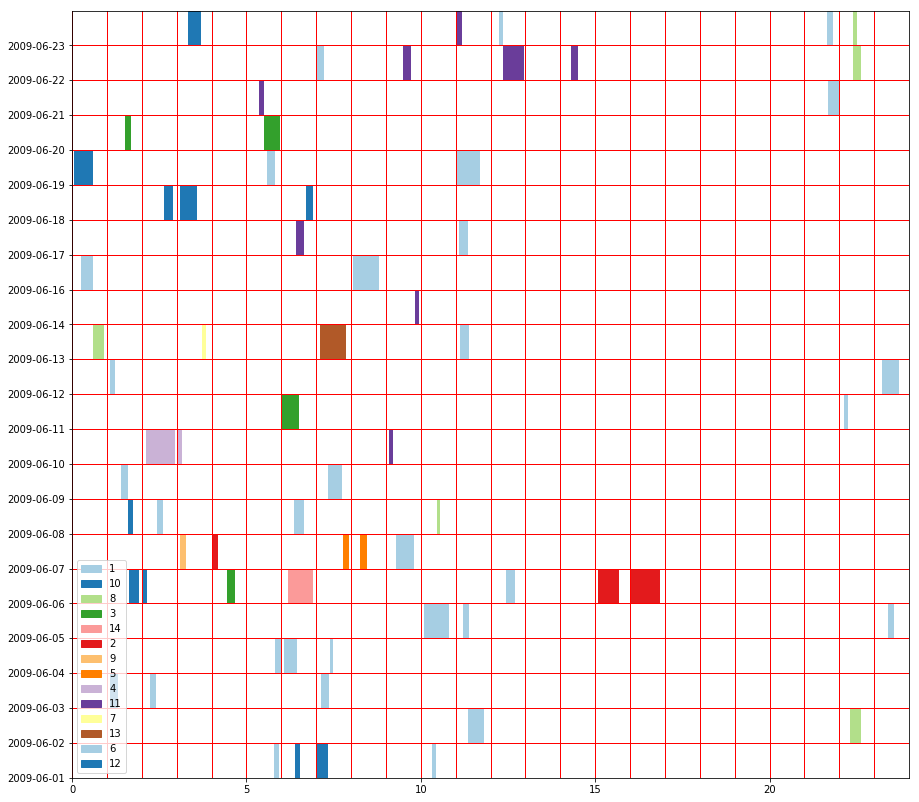

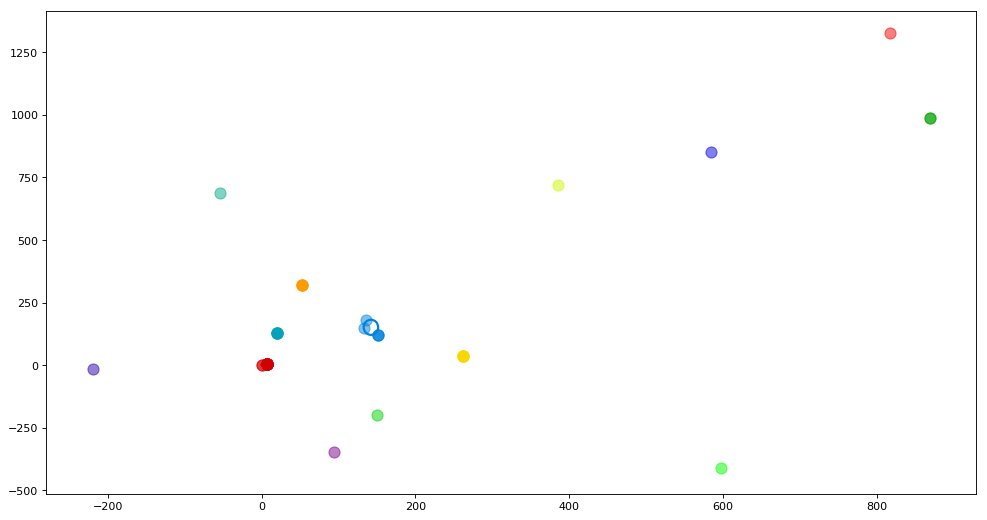

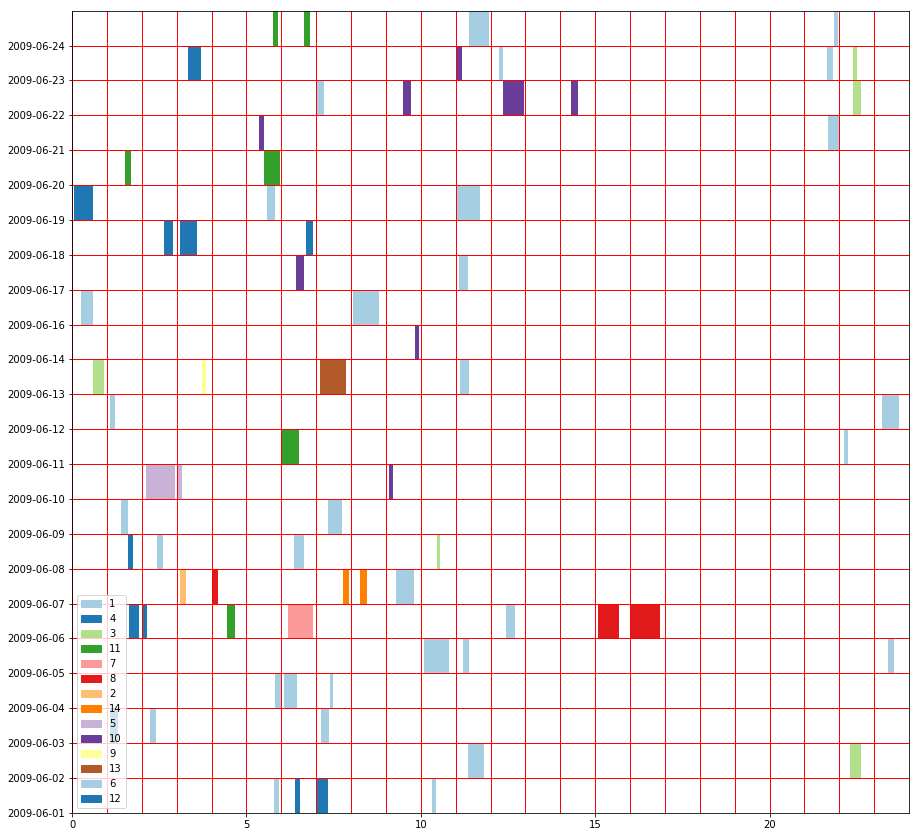

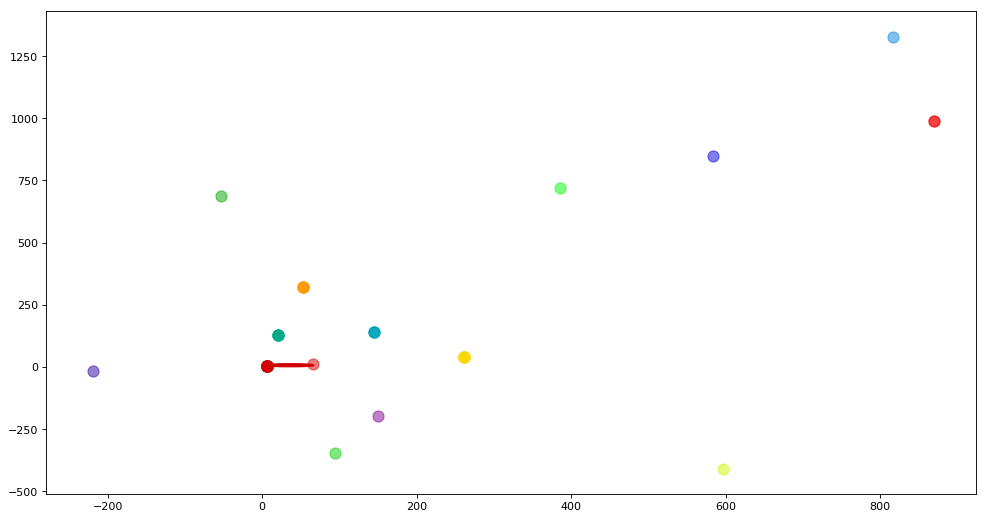

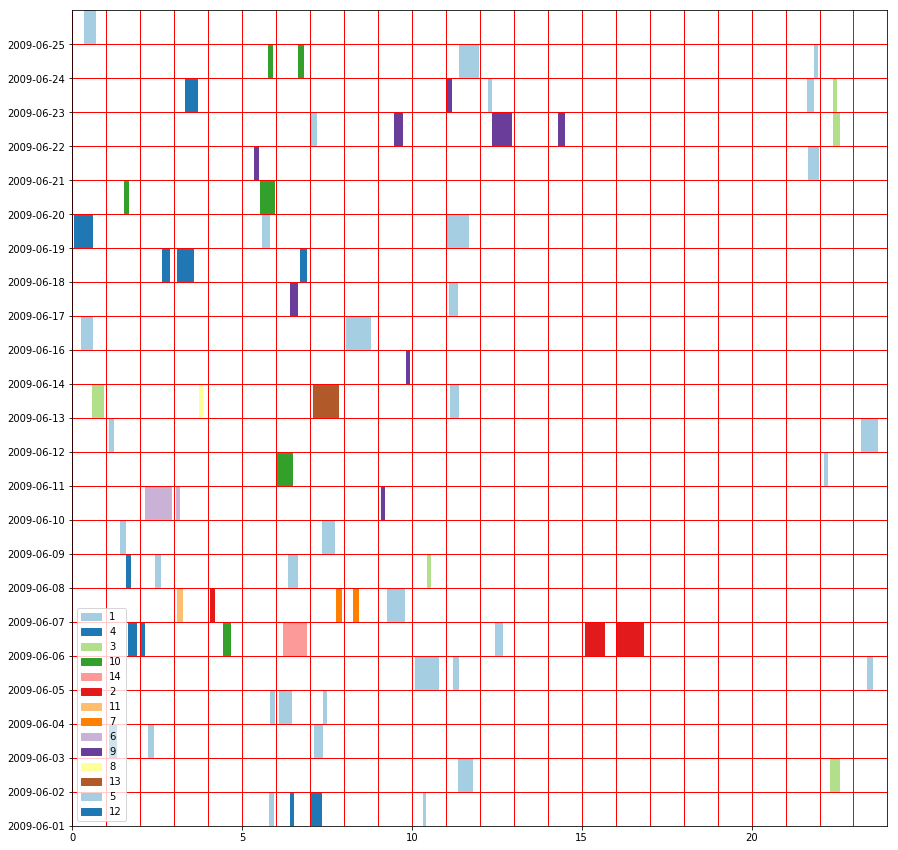

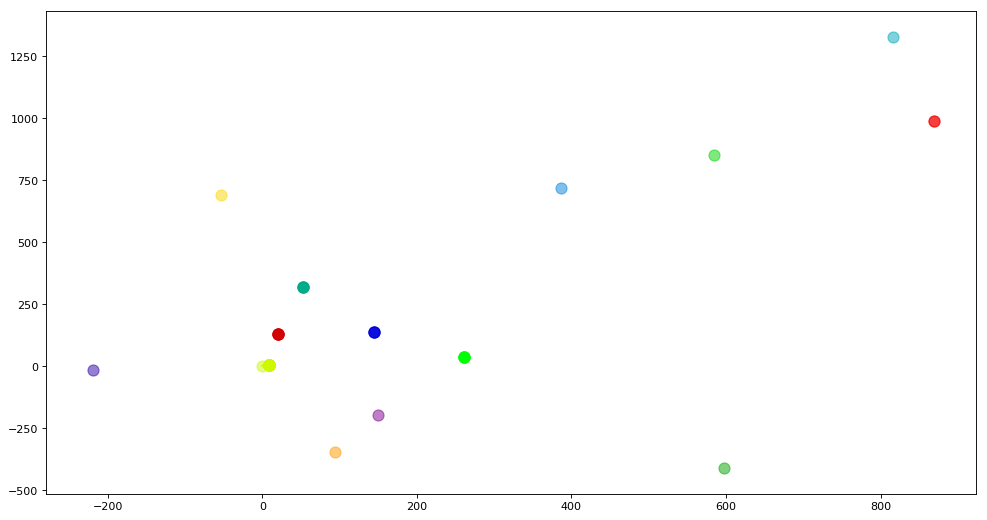

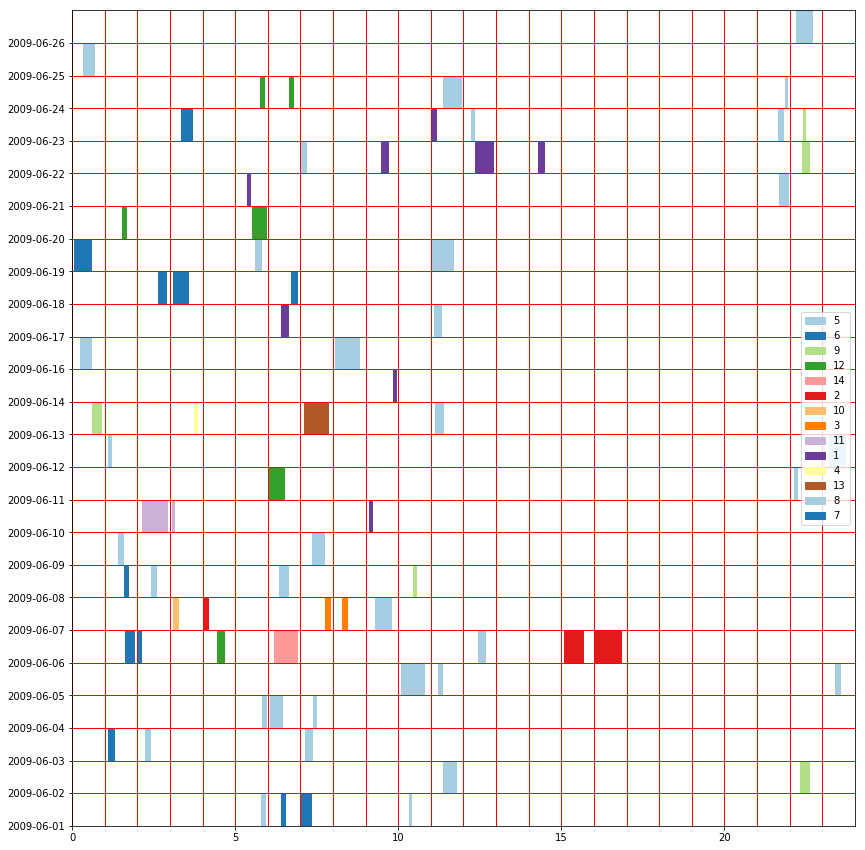

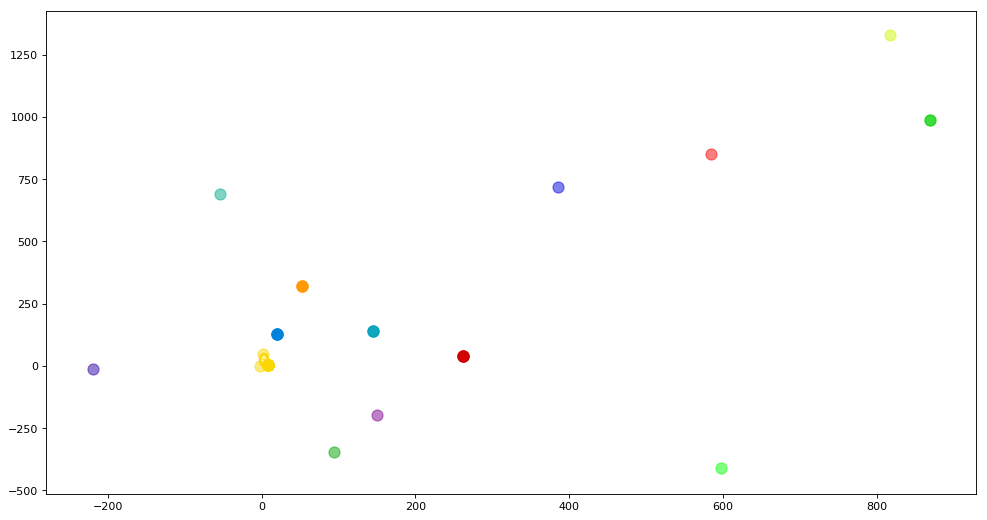

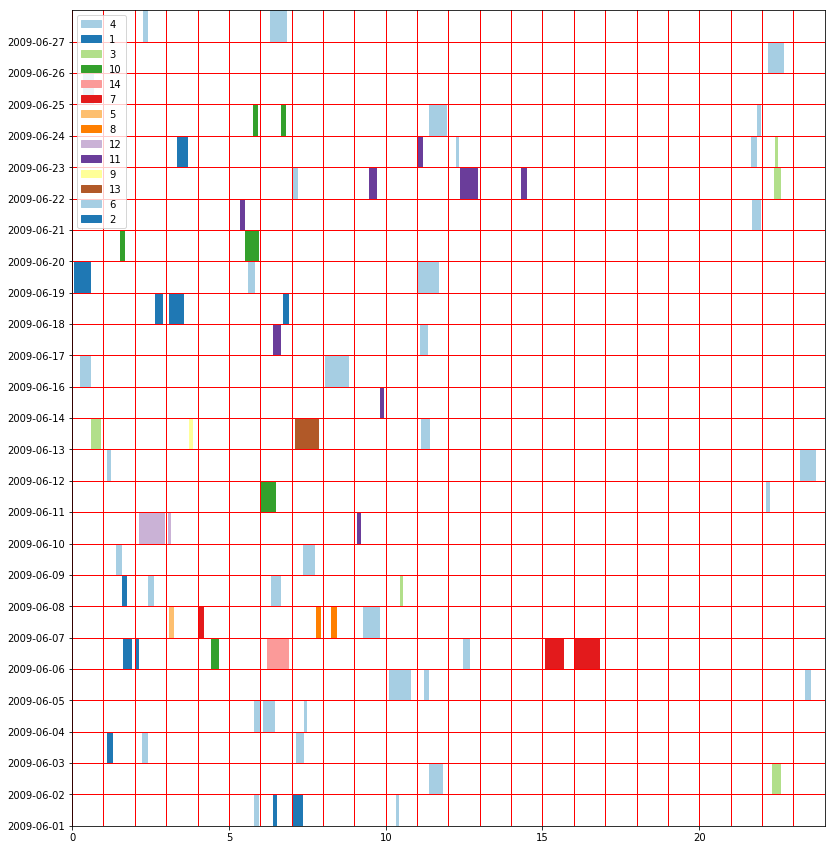

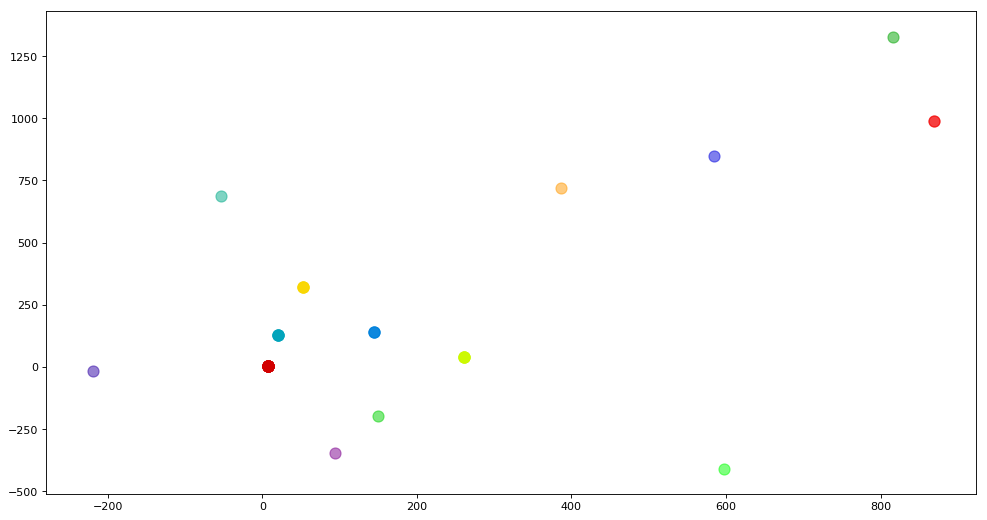

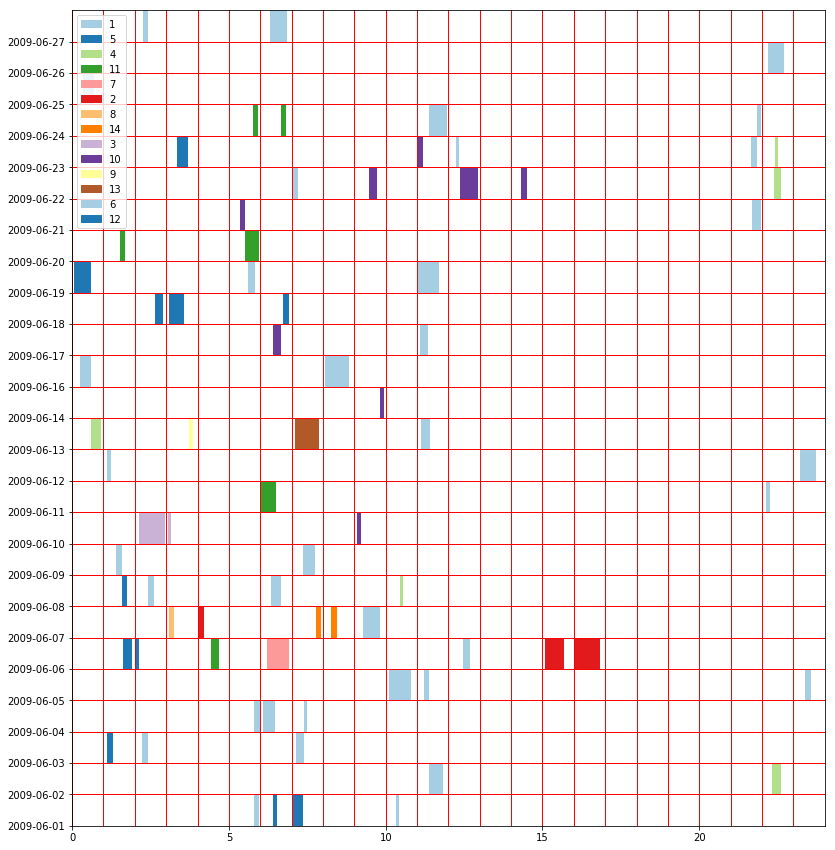

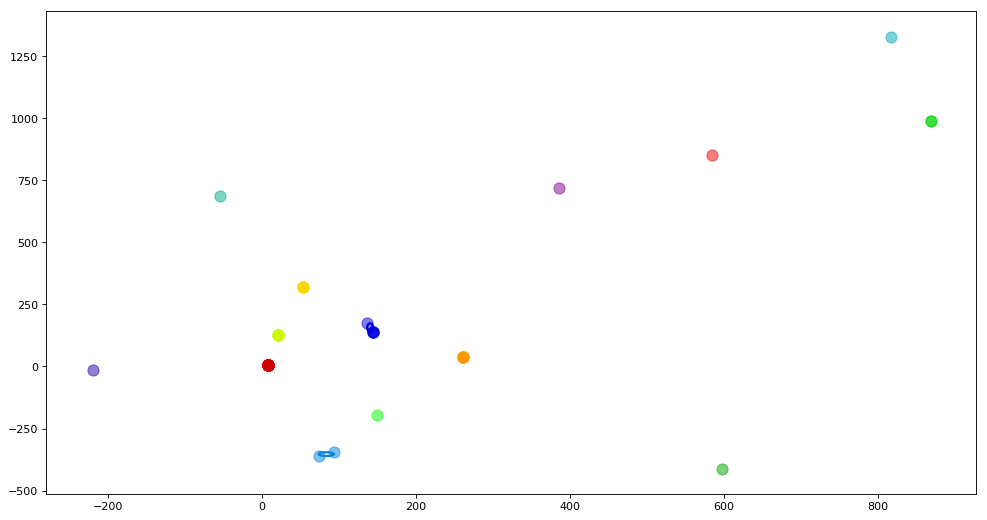

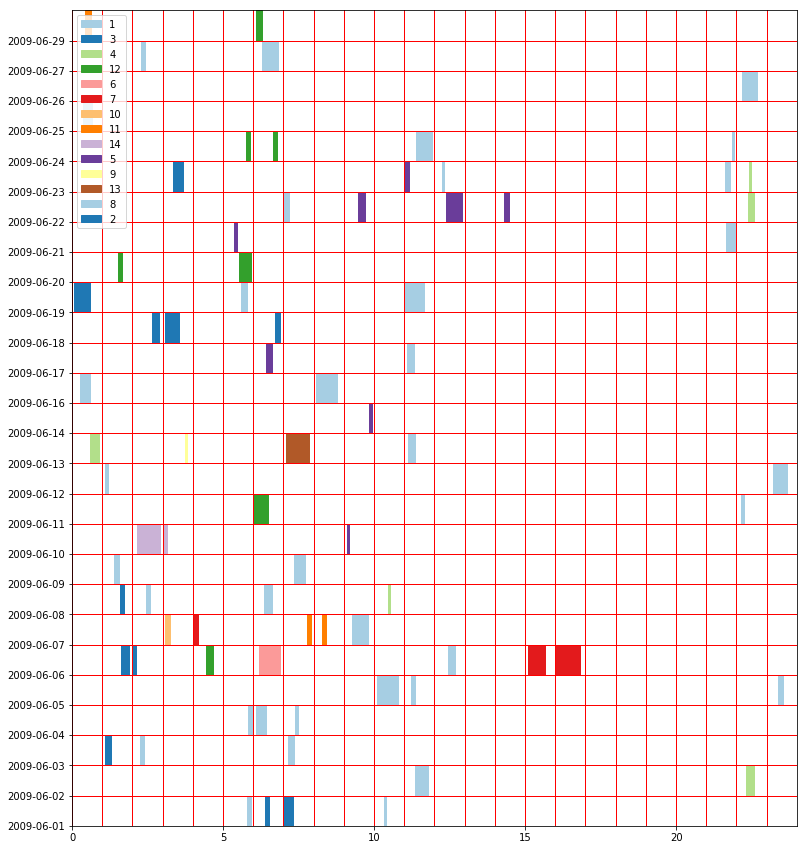

In [2]:
import random
import glob
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime as dt
import seaborn as sns
import math 
import os
import errno
import matplotlib.patches as patches
from copy import deepcopy
from sklearn.cluster import KMeans
from sklearn import metrics
from scipy.spatial.distance import cdist
from matplotlib.patches import Ellipse, Circle
import operator
import pdb
from geopy.geocoders import Nominatim

pd.options.mode.chained_assignment = None


#-------------------------------
def prepare_dfs():
    global cluster_hourly_df    
    
    #create cluster_hourly_df columns
    for i in range(0, 24):
        cluster_hourly_df['Date'] = 0
        cluster_hourly_df['ClusterId'] = 0
        cluster_hourly_df['AvgLat'] = 0
        cluster_hourly_df['AvgLon'] = 0
        cluster_hourly_df[i] = 0
        
#------------------------------------------------------------------------------------
#Find distance between two lan:lon points in meters
def meters(lat1, lon1, lat2, lon2):  
    R = 6378.137 # Radius of earth in KM
    dLat = lat2 * math.pi / 180 - lat1 * math.pi / 180
    dLon = lon2 * math.pi / 180 - lon1 * math.pi / 180
    a = math.sin(dLat/2) * math.sin(dLat/2) + math.cos(lat1 * math.pi / 180) * math.cos(lat2 * math.pi / 180) * math.sin(dLon/2) * math.sin(dLon/2);
    c = 2 * math.atan2(math.sqrt(a), math.sqrt(1-a));
    d = R * c
    return d * 1000 # meters

#---------------------------------------------------------------------------------------------------
def find_best_k(X):
    MAX_CLUSTERS = len(X)

    # Start clustering number hashes using temporal features
    k_fitted_models = []
    for k in range(1, MAX_CLUSTERS+1):
        if(k > len(X)):
            break
        algo = KMeans(n_clusters = k, init='k-means++', verbose = 0)
        fitted = algo.fit(X)
        k_fitted_models.append(fitted)

    # Compute best k value based the elbow method
    inertias = np.asarray([fitted.inertia_ for fitted in k_fitted_models])
    gradients = -np.diff(np.asarray([fitted.inertia_ for fitted in k_fitted_models]))

    delta_x = inertias[0]/MAX_CLUSTERS

    sum_couples = [(sum(gradients[0:k]), inertias[k]) for k in range(1,len(gradients))]
    atan_couples = [(sum_couples[k][0]/((k+1)*delta_x), sum_couples[k][1]/((len(gradients)-(k+1))*delta_x)) for k in range(len(sum_couples))]
    angle_couples = [(math.atan(atan_couples[k][0])*180/math.pi, math.atan(atan_couples[k][1])*180/math.pi) for k in range(0,len(atan_couples))]
    elbow_angles= [180-(angle_couples[k][0]-angle_couples[k][1]) for k in range(0,len(angle_couples))]

    best_k = min(enumerate(elbow_angles), key=operator.itemgetter(1))[0]+1
    
    #import pdb; pdb.set_trace()
    return best_k

#---------------------------------------------------------------------------------------------------
def k_mean_on_stay_points():
    global staypts_df
    global cluster_hourly_df
    global clus_dict
    
    data = cluster_hourly_df[["ClusterId", "AvgLat", "AvgLon"]]
    #data = data.drop_duplicates()
    data = data.reset_index(drop=True)
    
    #calculate x and y from Avg Lat and Avg Lon
    #assign the first lat and log as the base for the plot i.e. origin
    origin_lat = math.radians(staypts_df["Latitude"][0])
    origin_lon = math.radians(staypts_df["Longitude"][0])
    
    #convert each lat and lon into x and y 
    EARTH_RAD = 6378100
    data['X'] = 0.0
    data['Y'] = 0.0
    for i in range(0, len(data)):
        x = 0
        y = 0
        current_lat = math.radians(data["AvgLat"][i])
        current_lon = math.radians(data["AvgLon"][i])
        x = ((math.cos(current_lat) + math.cos(origin_lat))/2) * EARTH_RAD * (current_lon - origin_lon) * math.pi / 180
        y = (current_lat - origin_lat)* math.pi/180 * EARTH_RAD
        data.at[i, 'X'] = x
        data.at[i, 'Y'] = y
        
    #import pdb; pdb.set_trace()
    f1 = data['X'].values
    f2 = data['Y'].values
    X = np.array(list(zip(f1, f2)))
    
    if len(X) <= 1:
        return
    
    # Best number of clusters
    for k in range(1, len(X)+1):
        recluster = 0
        # Number of clusters
        kmeans = KMeans(n_clusters=k)
        # Fitting the input data
        kmeans = kmeans.fit(X)
        # Getting the cluster labels
        labels = kmeans.predict(X)

        for i in range(k):
            points = np.array([X[j] for j in range(len(X)) if labels[j] == i])
            x2 = max(points[:, 0])
            x1 = min(points[:, 0])
            y2 = max(points[:, 1])
            y1 = min(points[:, 1])
            
            #if any cluster has diamiter greater than 100, then increase k and recluster
            if ((x2 - x1) >= k_mean_radius) or ((y2 - y1) >= k_mean_radius):    
                recluster = 1
        
        if recluster == 0:
            best_k = k
            break
   
    #adding the cluster labels as new cluster ids
    data["NewClusterId"] = labels + 1
    
    colors = sns.color_palette("nipy_spectral_r", k)

    fig, ax = plt.subplots(figsize=(15, 8), dpi=80)

    for i in range(best_k):
        points = np.array([X[j] for j in range(len(X)) if labels[j] == i])
        x2 = max(points[:, 0])
        x1 = min(points[:, 0])
        y2 = max(points[:, 1])
        y1 = min(points[:, 1])
        #import pdb; pdb.set_trace()
        centre_x = (x2+x1)/2
        centre_y = (y2+y1)/2
        
        ellipse = Ellipse(xy=(centre_x, centre_y), width=(x2-x1), height=(y2-y1), edgecolor=colors[i], fc='None', lw=2)
        ax.add_patch(ellipse)
        #circ = Circle((centre_x, centre_y), rad+5, edgecolor=colors[i], fc='None', lw=2)
        #ax.add_patch(circ)
        ax.scatter(points[:, 0], points[:, 1], s=100, edgecolor=colors[i], alpha=0.5, c = colors[i])
    
    #plt.xlim(-500, 500)
    #plt.ylim(-500, 500)
    plt.show()
    
    #create a dictionary for old-new cluster ids
    clus_dict = pd.Series(data.NewClusterId.values,index=data.ClusterId).to_dict()
    
    #update for new cluster ids in all dfs
    for i in range(0, len(cluster_hourly_df)):
        #cluster_hourly_df["DistanceCluster"][i] = clus_dict.get(cluster_hourly_df["ClusterId"][i])
        cluster_hourly_df["ClusterId"][i] = clus_dict.get(cluster_hourly_df["ClusterId"][i])
                                                          
    cluster_hourly_df['AvgLat'] = cluster_hourly_df.groupby('ClusterId')['AvgLat'].transform(np.mean)
    cluster_hourly_df['AvgLon'] = cluster_hourly_df.groupby('ClusterId')['AvgLon'].transform(np.mean)
    cluster_hourly_df = cluster_hourly_df.groupby(['Date', 'ClusterId', 'AvgLat', 'AvgLon']).sum()
    cluster_hourly_df = cluster_hourly_df.reset_index(level=[0,1,2,3])
    
    for i in range(0, len(staypts_df)):
        #staypts_df["DistanceCluster"][i] = clus_dict.get(staypts_df["ClusterId"][i])
        staypts_df["ClusterId"][i] = clus_dict.get(staypts_df["ClusterId"][i])
    
    staypts_df['ClusterMeanLat'] = staypts_df.groupby('ClusterId')['Latitude'].transform(np.mean)
    staypts_df['ClusterMeanLon'] = staypts_df.groupby('ClusterId')['Longitude'].transform(np.mean)
    
    
#------------------------------------------------------------------------------------
def cluster(newlat, newlon, row, count):
    global curr_hr_df
    
    currcluster = curr_hr_df['ClusterId'][row-1]
    curr_hr_df['ClusterId'][row] = -1
    curr_hr_df['ClusterMeanLat'][row] = -1.0
    curr_hr_df['ClusterMeanLon'][row] = -1.0
    curr_hr_df['StayPoint'][row] = -1
    clulat = curr_hr_df['ClusterMeanLat'][row-1]
    clulon = curr_hr_df['ClusterMeanLon'][row-1]
    
    if meters(clulat, clulon, newlat, newlon)<= staypts_distance:
        curr_hr_df['ClusterId'][row] = currcluster
        curr_hr_df['ClusterMeanLat'] = curr_hr_df.groupby('ClusterId')['Latitude'].transform(np.mean)
        curr_hr_df['ClusterMeanLon'] = curr_hr_df.groupby('ClusterId')['Longitude'].transform(np.mean)
        count = count + 1
    else:
        
        if count >= 2:
            MinClusTime = curr_hr_df['Timestamp'][row-count]
            MaxClusTime = curr_hr_df['Timestamp'][row-1]
            k = MaxClusTime - MinClusTime
            l = (k / np.timedelta64(1, 'm')).astype(int)
            
            if (l >= staypts_time):
                curr_hr_df.loc[ (curr_hr_df['ClusterId']==currcluster), 'StayPoint'] = 1
        count = 1
        curr_hr_df['ClusterMeanLat'][row] = curr_hr_df['Latitude'][row]
        curr_hr_df['ClusterMeanLon'][row] = curr_hr_df['Longitude'][row]
        curr_hr_df['ClusterId'][row] = currcluster + 1
    return count

#------------------------------------------------------------------------------------
def read_usr_file():
    global usr_trejec_df
    
    #Load file names for user
    filenames = glob.glob(file_source_raw)

    #Read the files
    list_of_dfs = [pd.read_csv(filename, skiprows=6, header = None) for filename in filenames]

    #put the data from list into one dataframe
    usr_trejec_df = pd.concat(list_of_dfs, ignore_index=True)
    usr_trejec_df.columns = ['Latitude', 'Longitude', '0', 'Altitude', 'NumDays', 'Date', 'Time']
    usr_trejec_df["Timestamp"] = usr_trejec_df["Date"].map(str) + " " + usr_trejec_df["Time"]
    
    usr_trejec_df.index = pd.to_datetime(usr_trejec_df.Timestamp)
    usr_trejec_df = usr_trejec_df.resample('1T').mean()
    usr_trejec_df = usr_trejec_df.dropna()
    
     #add columns to user trajectory dataframe
    #1. add timestamp as column
    usr_trejec_df['Timestamp'] = pd.to_datetime(usr_trejec_df.index)
    #restore date and time column
    usr_trejec_df['Date'] = usr_trejec_df.Timestamp.dt.date
    usr_trejec_df['Time'] = usr_trejec_df.Timestamp.dt.time
    #2. add hour as column
    usr_trejec_df['Hour'] = usr_trejec_df.Timestamp.dt.hour
    #3. add weekday number.name as column
    usr_trejec_df['Weekday'] = usr_trejec_df['Timestamp'].dt.weekday.map(str) + usr_trejec_df['Timestamp'].dt.weekday_name
    #4. ClusterId, 5. ClusterMeanLat, 6. ClusterMeanLon, 7. StayPoint, 8. DistanceCluster
    usr_trejec_df['ClusterId'] = -1
    usr_trejec_df['ClusterMeanLat'] = -1.0
    usr_trejec_df['ClusterMeanLon'] = -1.0
    usr_trejec_df['StayPoint'] = -1
    
    #remove columns not used
    usr_trejec_df = usr_trejec_df.drop(['0', 'Altitude', 'NumDays'], axis = 1)
    
    #sort the trajectory based on date and time
    usr_trejec_df = usr_trejec_df.sort_values(['Date', 'Time'])
    
    #reset index
    usr_trejec_df = usr_trejec_df.reset_index(drop=True)

#------------------------------------------------------------------------------------
def read_trained_model():
    global trained_model_df
    
    if os.path.isfile(dest_file_final_markov_chain):
        trained_model_df = pd.read_csv(dest_file_final_markov_chain, header = 0, sep="\t")
    
#------------------------------------------------------------------------------------
def create_last_hr_staypts():
    global curr_hr_df 
    global staypts_df
    global curr_hr_staypts_df
    
    #clear current hour staypoints dataframe
    curr_hr_staypts_df = curr_hr_staypts_df.iloc[0:0]
    
    #reset index
    curr_hr_df = curr_hr_df.reset_index(drop=True)
    
    #Read the file in an online manner as the points come and assign the points to clusters
    row =1
    count = 1
    if not staypts_df.empty:
        curr_hr_df['ClusterId'][row-1] = staypts_df['ClusterId'].max() + 1
    else:
        curr_hr_df['ClusterId'][row-1] = 1
    
    curr_hr_df['ClusterMeanLat'][row-1] = curr_hr_df['Latitude'][0]
    curr_hr_df['ClusterMeanLon'][row-1] = curr_hr_df['Longitude'][0]
    curr_hr_df['StayPoint'][row-1] = -1
    
    while row < len(curr_hr_df):
        count = cluster(curr_hr_df['Latitude'][row], curr_hr_df['Longitude'][row], row, count)
        row= row + 1
    
    #copy the staypoints to the current hour staypoints dataframe
    curr_hr_staypts_df = curr_hr_df.loc[curr_hr_df['StayPoint'] == 1]
    #copy the stay points into another dataframe
    staypts_df = staypts_df.append(curr_hr_df.loc[curr_hr_df['StayPoint'] == 1])
    #reset staypoints index
    curr_hr_staypts_df.index = curr_hr_staypts_df['Timestamp']
    staypts_df.index = staypts_df['Timestamp']
    #clear current hour dataframe
    curr_hr_df = curr_hr_df.iloc[0:0]
    
#------------------------------------------------------------------------------------

def cal_hourly_cluster_weight():
    global curr_hr_staypts_df
    global cluster_hourly_df   
    
    curr_hr_cluster_hourly_df = pd.DataFrame()       
    
    last_hour = curr_hr_staypts_df['Timestamp'][0].hour
    last_clusid = curr_hr_staypts_df['ClusterId'][0]
    curr_count = 0
    j = 0
    
    for i in range(0, 24):
        curr_hr_cluster_hourly_df['Date'] = 0
        curr_hr_cluster_hourly_df['ClusterId'] = 0
        curr_hr_cluster_hourly_df['AvgLat'] = 0
        curr_hr_cluster_hourly_df['AvgLon'] = 0
        curr_hr_cluster_hourly_df[i] = 0
    
    for i in range(0, len(curr_hr_staypts_df)):

        if (i == len(curr_hr_staypts_df)-1):
            
            k = curr_hr_staypts_df['Timestamp'][i] - curr_hr_staypts_df['Timestamp'][i-curr_count]
            l = (k / np.timedelta64(1, 'm')).astype(int)
            
            date_read = curr_hr_staypts_df.index[i].date()
            cluster_id = curr_hr_staypts_df['ClusterId'][i]
            ClusterMeanLat = curr_hr_staypts_df['ClusterMeanLat'][i]
            ClusterMeanLon = curr_hr_staypts_df['ClusterMeanLon'][i]
            col_name = curr_hr_staypts_df.index[i].hour

            curr_hr_cluster_hourly_df.loc[j,'AvgLat'] = ClusterMeanLat
            curr_hr_cluster_hourly_df.loc[j,'AvgLon'] = ClusterMeanLon
            curr_hr_cluster_hourly_df.loc[j,'Date'] = date_read
            curr_hr_cluster_hourly_df.loc[j,'ClusterId'] = cluster_id
            curr_hr_cluster_hourly_df.loc[j, col_name] = round((l)/60,4)
            
        if (curr_hr_staypts_df['Timestamp'][i].hour != last_hour) | (curr_hr_staypts_df['ClusterId'][i] != last_clusid):
            #import pdb; pdb.set_trace()

            if (curr_count == 1) & (curr_hr_staypts_df['Timestamp'][i].hour != last_hour):
                k = ((curr_hr_staypts_df['Timestamp'][i-1] + pd.Timedelta(hours=1) - 
                      pd.Timedelta(minutes=curr_hr_staypts_df['Timestamp'][i-1].minute)) - 
                     curr_hr_staypts_df['Timestamp'][i-1])
            else:
                k = curr_hr_staypts_df['Timestamp'][i-1] - curr_hr_staypts_df['Timestamp'][i-curr_count]

            l = (k / np.timedelta64(1, 'm')).astype(int)
            date_read = curr_hr_staypts_df.index[i-1].date()
            cluster_id = curr_hr_staypts_df['ClusterId'][i-1]
            ClusterMeanLat = curr_hr_staypts_df['ClusterMeanLat'][i-1]
            ClusterMeanLon = curr_hr_staypts_df['ClusterMeanLon'][i-1]
            col_name = curr_hr_staypts_df.index[i-1].hour

            curr_hr_cluster_hourly_df.loc[j, 'AvgLat'] = ClusterMeanLat
            curr_hr_cluster_hourly_df.loc[j, 'AvgLon'] = ClusterMeanLon
            curr_hr_cluster_hourly_df.loc[j, 'Date'] = date_read
            curr_hr_cluster_hourly_df.loc[j, 'ClusterId'] = cluster_id
            curr_hr_cluster_hourly_df.loc[j, col_name] = round((l)/60,4)
            j = j + 1
            curr_count = 1

            if (curr_hr_staypts_df['Timestamp'][i].hour != last_hour):
                last_hour = curr_hr_staypts_df['Timestamp'][i].hour
            if (curr_hr_staypts_df['ClusterId'][i] != last_clusid):
                last_clusid = curr_hr_staypts_df['ClusterId'][i]
        else:
            curr_count = curr_count + 1

    curr_hr_cluster_hourly_df = curr_hr_cluster_hourly_df.fillna(0)
    curr_hr_cluster_hourly_df = curr_hr_cluster_hourly_df.groupby(['Date', 'ClusterId', 'AvgLat', 'AvgLon']).sum()
    curr_hr_cluster_hourly_df = curr_hr_cluster_hourly_df.reset_index(level=[0,1,2,3])
   
    cluster_hourly_df = cluster_hourly_df.append(curr_hr_cluster_hourly_df, ignore_index=True)
    cluster_hourly_df = cluster_hourly_df.reset_index(drop=True)
    
#-------------group_clusters-----------------------------------------------------------------------
def group_clusters():
    global staypts_df
    
    #this fucntion groups the clusters together from different days 
    #Copy the stay points dataframe into another dataframe and remove duplicates
    staypts_df1 = staypts_df[['ClusterId', 'ClusterMeanLat', 'ClusterMeanLon']].copy()
    staypts_df1 = staypts_df1.drop_duplicates(subset=['ClusterId', 'ClusterMeanLat', 'ClusterMeanLon'])

    staypts_df1 = staypts_df1.sort_values(['ClusterMeanLat', 'ClusterMeanLon'])

    row = 1
    for i in range(0, len(staypts_df1)):
        for j in range(i+1, len(staypts_df1)):
        
            chk_cluster = staypts_df1['ClusterId'][i]
            chk_clulat = staypts_df1['ClusterMeanLat'][i]
            chk_clulon = staypts_df1['ClusterMeanLon'][i]
            curr_cluster = staypts_df1['ClusterId'][j]
            curr_clulat = staypts_df1['ClusterMeanLat'][j]
            curr_clulon = staypts_df1['ClusterMeanLon'][j]
        
            if meters(chk_clulat, chk_clulon, curr_clulat, curr_clulon)<= staypts_distance:
                staypts_df.loc[ (staypts_df['ClusterId']==curr_cluster), 'ClusterId'] = chk_cluster
                staypts_df['ClusterMeanLat'] = staypts_df.groupby('ClusterId')['ClusterMeanLat'].transform(np.mean)
                staypts_df['ClusterMeanLon'] = staypts_df.groupby('ClusterId')['ClusterMeanLon'].transform(np.mean)
            else:
                break

#------------------------------------------------------------------------------------------------
def visualize_hourly_cluster_weight():
    global staypts_df
    
    #create a color dictionary for each cluster for the plot
    dicts = {}
    clu_list = []
    clu_list = staypts_df['ClusterId'].unique()
    #r = lambda: random.randint(0,255)
    colors = sns.color_palette("Paired", len(clu_list))
    
    for i in range(0, len(clu_list)):
        dicts[clu_list[i]] = (colors[i])
        #dicts[clu_list[i]] = ('#%02X%02X%02X' % (r(),r(),r()))
        
    #create a new graph where we will later add rectangles for each hour:cluster
    fig2 = plt.figure(figsize=(15,15))
    ax1 = fig2.add_subplot(111, aspect='equal')

    #get all the dates for y axis
    date_list = staypts_df['Timestamp'].dt.date.unique()
    y = range(0, len(date_list))
    def_yticks = date_list
    plt.yticks(y, def_yticks)
    
    #set the x axis limit from 0-24 hours of a day, y axis with dates
    limsx = (0, 24)
    limsy = (0, len(date_list))

    date_counter = 0
    last_date = staypts_df['Timestamp'][0].date()
    last_hour = staypts_df['Timestamp'][0].hour
    last_clusid = staypts_df['ClusterId'][0]
    curr_count = 0
    j = 0
    
    #drawing verical lines for each hour
    for i in range(0, 24):
        ax1.axvline(x= i, linewidth=1, color='r')

    for i in range(0, len(staypts_df)):
        #import pdb; pdb.set_trace()
        
        if (i == len(staypts_df)-1):
            a = staypts_df['Timestamp'][i-curr_count].hour + staypts_df['Timestamp'][i-curr_count].minute/60
            b = staypts_df['Timestamp'][i].hour + staypts_df['Timestamp'][i].minute/60
            width = b - a
            height = 1
            col_id = dicts.get(staypts_df['ClusterId'][i])
            ax1.add_patch(patches.Rectangle((a, date_counter), width, height, color=col_id, label=staypts_df['ClusterId'][i]))
            
        #plot a rectangle if the hour or clusterid or date has changed
        if ((staypts_df['Timestamp'][i].hour != last_hour) | (staypts_df['ClusterId'][i] != last_clusid)
           | (last_date != staypts_df['Timestamp'][i].date())):

            if (curr_count == 1) & (staypts_df['Timestamp'][i].hour != last_hour):
                a = staypts_df['Timestamp'][i-curr_count].hour + 1
            else:
                a = staypts_df['Timestamp'][i-curr_count].hour + staypts_df['Timestamp'][i-curr_count].minute/60

            b = staypts_df['Timestamp'][i-1].hour + staypts_df['Timestamp'][i-1].minute/60

            width = b - a
            height = 1
            col_id = dicts.get(staypts_df['ClusterId'][i-1])
            ax1.add_patch(patches.Rectangle((a, date_counter), width, height, color=col_id, label=staypts_df['ClusterId'][i-1]))

            curr_count = 1

            if (staypts_df['Timestamp'][i].hour != last_hour):
                last_hour = staypts_df['Timestamp'][i].hour
            if (staypts_df['ClusterId'][i] != last_clusid):
                last_clusid = staypts_df['ClusterId'][i]
            if (last_date != staypts_df['Timestamp'][i].date()):
                date_counter = date_counter + 1
                last_date = staypts_df['Timestamp'][i].date()
                ax1.axhline(y= date_counter, linewidth=1, color='r')

        else:
            curr_count = curr_count + 1
            
    handles, labels = ax1.get_legend_handles_labels()
    handle_list, label_list = [], []
    for handle, label in zip(handles, labels):
        if label not in label_list:
            handle_list.append(handle)
            label_list.append(label)
    plt.legend(handle_list, label_list)

    plt.xlim(limsx)
    plt.ylim(limsy)
    plt.show()
#-----------------------------------------------------------------------------------
def update_staypts_csv():
     with open(dest_file_staypoints, 'a') as f:
             (staypts_df).to_csv(f,  sep='\t', encoding='utf-8')
#-----------------------------------------------------------------------------------
def update_hourly_weights_csv():
    with open(dest_file_hourly_weights, 'a') as f:
             (cluster_hourly_df).to_csv(f,  sep='\t', encoding='utf-8')
#------------------------------------------------------------------------------------
def create_save_seperate_trasition_matrices():
    date_list = cluster_hourly_df['Date'].unique()
    
    #create a temp dataframe for each data, and calculate trasition matrices from hour t to t+1
    for p in range(0, cluster_hourly_df['Date'].nunique()):

        #create a temp dataframe for pervious date
        temp_df = pd.DataFrame()
        matrices_df = pd.DataFrame()
        temp_df = cluster_hourly_df.loc[cluster_hourly_df['Date'] == date_list[p]]
        temp_df = temp_df.reset_index(drop=True)

        for i in range(0, 24):
            matrices_df['Date'] = 0
            matrices_df['ClusterId'] = 0
            for j in range(0, len(temp_df)):
                colname = '(' + str(i) + '-' + str(i+1) + ')-' + str(temp_df['ClusterId'][j])
                matrices_df[colname] = 0

        matrices_df['Date'] = temp_df['Date']
        matrices_df['ClusterId'] = temp_df['ClusterId']

        for i in range (0, 23):
            for j in range (0, len(temp_df)):
                for k in range (0, len(temp_df)):
                    prob = temp_df[i][j] * temp_df[i+1][k]
                    colname = '(' + str(i) + '-' + str(i+1) + ')-' + str(temp_df['ClusterId'][k])
                    matrices_df[colname][j] = prob
        file_name = dest_path_each_day_trsn_mat + str(date_list[p]) + ".csv"
        matrices_df.to_csv(file_name, sep='\t', encoding='utf-8')

#------------------------------------------------------------------------------------
def create_save_markov_chains():
    global final_transition_df
    global co_loc
    
    final_transition_df = pd.DataFrame()
    
    #create an empty markov chain frame for each clusterid as state, and transition for each hour of the day
    date_list = cluster_hourly_df['Date'].unique()
    cluster_list = cluster_hourly_df['ClusterId'].unique()
    AvgLat_list = cluster_hourly_df['AvgLat'].unique()
    AvgLon_list = cluster_hourly_df['AvgLon'].unique()
    
    for i in range(0, 24):
        final_transition_df['Address'] = 0
        final_transition_df['AvgLat'] = 0
        final_transition_df['AvgLon'] = 0
        final_transition_df['ClusterId'] = 0
        for j in range(0, cluster_hourly_df['ClusterId'].nunique()):
            colname = '(' + str(i) + '-' + str(i+1) + ')-' + str(cluster_list[j])
            final_transition_df[colname] = 0
          
    final_transition_df['ClusterId'] = cluster_list
    final_transition_df['AvgLat'] = AvgLat_list
    final_transition_df['AvgLon'] = AvgLon_list
    final_transition_df = final_transition_df.fillna(0)
    final_transition_df.index = final_transition_df.ClusterId

    #read each day file and sum the matching rows:cols combinations
    date_list = cluster_hourly_df['Date'].unique()
    path_dir = dest_path_each_day_trsn_mat

    
    for p in range(0, cluster_hourly_df['Date'].nunique()):
        temp_df = pd.DataFrame()
        filename = path_dir + str(date_list[p]) + '.csv'
        temp_df =  pd.read_csv(filename, header = 0, sep='\t')

        for i in range(0, len(temp_df)):
            rowname = temp_df['ClusterId'][i]
            for src_column in temp_df:
                for dest_column in final_transition_df:
                    if src_column == dest_column and src_column != 'ClusterId' :
                        #import pdb; pdb.set_trace()
                        final_transition_df[dest_column][rowname] = (final_transition_df[dest_column][rowname] +
                                                                    temp_df[src_column][i])

    #calculate probability from cluster x to cluster y from time t to t+1
    final_transition_df = final_transition_df.reset_index(drop=True)
    for clus in range(0, len(final_transition_df)):
        for i in range(0, 24):
            temp_sum = 0
            for j in range(0, len(final_transition_df)):
                colname = '(' + str(i) + '-' + str(i+1) + ')-' + str(final_transition_df['ClusterId'][j])
                temp_sum += (final_transition_df[colname][clus])
            for k in range(0, len(final_transition_df)):
                colname = '(' + str(i) + '-' + str(i+1) + ')-' + str(final_transition_df['ClusterId'][k])
                if temp_sum != 0:
                    final_transition_df[colname][clus] = final_transition_df[colname][clus]/temp_sum
    
    #create dictionary for coordinate : address
    points = tuple(zip(final_transition_df.AvgLat, final_transition_df.AvgLon))
    geocoder = Nominatim(timeout=10)
    coordinate_location = {}
    
    for coordinate in points:
        try:
            location = geocoder.reverse(coordinate)
        except:
            location = 'unknown'
        coordinate_location[coordinate] = location
    
    co_loc = {k:v for k,v in coordinate_location.items()}

    for i in range(0, len(final_transition_df)):
        address = co_loc.get((final_transition_df['AvgLat'][i], final_transition_df['AvgLon'][i]))
        if address == 'unknown':
            final_transition_df['Address'][i] = 'unknown'
        else:
            final_transition_df['Address'][i] = address[0]
    
    #replace zero probabilities to a small value and save the file
    final_transition_df = final_transition_df.fillna(0)                    
    final_transition_df = final_transition_df.replace(0, 0.00001)
    final_transition_df.to_csv(dest_file_final_markov_chain, sep='\t')
    
    for i in range(0, 24):
        final_transition_temp_df = pd.DataFrame()
        k = cluster_hourly_df['ClusterId'].nunique()*i + 4
        final_transition_temp_df = final_transition_df.iloc[:,k:k + cluster_hourly_df['ClusterId'].nunique()]
        final_transition_temp_df.index = cluster_list
        file_name = usr_markov_chains_directory + "/" + str(i) + " hour.csv"
        final_transition_temp_df.to_csv(file_name, sep='\t', encoding='utf-8')
        
        
#------------------------------------------------------------------------------------
def predict(new_hour):
    global trained_model_df
    global curr_hr_staypts_df
    
    tobepredicted_df = curr_hr_staypts_df[['ClusterId', 'ClusterMeanLat', 'ClusterMeanLon', 'Timestamp']]
    tobepredicted_df = tobepredicted_df.drop_duplicates()
    tobepredicted_df = tobepredicted_df.reset_index(drop=True)

    for j in range(0, len(tobepredicted_df)):
        new_lat = tobepredicted_df['ClusterMeanLat'][j]
        new_lon = tobepredicted_df['ClusterMeanLon'][j]
        file_name = "Predicted Timestamp - " +  str(tobepredicted_df['Timestamp'][j]) + ".csv"
        for i in range(0, len(trained_model_df)):

            trn_lat = trained_model_df['AvgLat'][i]
            trn_lon = trained_model_df['AvgLon'][i]
            if meters(trn_lat, trn_lon, new_lat, new_lon) <= k_mean_radius * 100:

                predic_df = pd.DataFrame()

                cluster_id = trained_model_df['ClusterId'][i]
                curr_lat = trained_model_df['AvgLat'][i]
                curr_lon = trained_model_df['AvgLon'][i]
                curr_add = trained_model_df['Address'][i]
                pred_loc = {"current":(cluster_id, curr_lat, curr_lon, curr_add)}

                from_col_no = trained_model_df['ClusterId'].nunique() * new_hour + 5
                to_col_no = from_col_no + trained_model_df['ClusterId'].nunique()
                predic_df = trained_model_df.iloc[i:i+1,from_col_no:to_col_no]
                predic_df = predic_df.T
                predic_df['ClusterId'] = cluster_id
                predic_df['SelectedCluster'] = predic_df.index
                predic_df['SelectedCluster'] = predic_df['SelectedCluster'].map(lambda x: x.split('-', 2)[-1])
                predic_df.columns = ['Probability', 'ClusterId', 'SelectedCluster']
                predic_df = predic_df.sort_values('Probability', ascending=False).head(10)
                predic_df['Address'] = 0
                predic_df['Latitude'] = 0.0
                predic_df['Longitude'] = 0.0
                predic_df = predic_df.reset_index(drop=True)

                for j in range (0, len(predic_df)):
                    #import pdb; pdb.set_trace()
                    clus_to_find = int(float(predic_df['SelectedCluster'][j]))
                    add = trained_model_df.loc[ (trained_model_df['ClusterId'] == clus_to_find), 'Address'].values[0]
                    lat = trained_model_df.loc[ (trained_model_df['ClusterId'] == clus_to_find), 'AvgLat'].values[0]
                    lon = trained_model_df.loc[ (trained_model_df['ClusterId'] == clus_to_find), 'AvgLon'].values[0]

                    predic_df.loc[j, 'Address'] = add
                    predic_df.loc[j, 'Latitude'] = lat
                    predic_df.loc[j, 'Longitude'] = lon
                file = dest_predicted_dir + file_name
                predic_df.to_csv(file, sep='\t', encoding='utf-8')
                break
            
#------------------------------------------ S T A R T -----------------------------------------------
#global dataframes used
#user raw trajectory dataframe
usr_trejec_df = pd.DataFrame()
#user trained model
trained_model_df = pd.DataFrame()
#current hour points
curr_hr_df = pd.DataFrame()
#current hour staypoints
curr_hr_staypts_df = pd.DataFrame()
#all staypoints
staypts_df = pd.DataFrame()
#hourly cluster
cluster_hourly_df = pd.DataFrame()
#final markov chains
final_transition_df = pd.DataFrame()

clus_dict = {}
co_loc = {}
global_clusterid = 0
pred_loc = {}
lat_array = []
lon_array = []
global_count = 0

#---------------------------------------------------------------------------------------------------------------------
#--------------------------------------CHANGE HERE FOR USER AND DATE RANGE--------------------------------------------
#---------------------------------------------------------------------------------------------------------------------

#Edit user name, and path locations for source and destination files
user = "041"


#destination paths
usr_directory = "/home/shashank/Documents/location/code/test prediction quality/test 3/results/User " + user
usr_hrly_wght_directory = "/home/shashank/Documents/location/code/test prediction quality/test 3/results/User " + user + "/hourlyweights"
usr_sty_pts_directory = "/home/shashank/Documents/location/code/test prediction quality/test 3/results/User " + user + "/staypoints"
usr_markov_chains_directory = "/home/shashank/Documents/location/code/test prediction quality/test 3/results/User " + user + "/markovchains"
dest_predicted_dir = "/home/shashank/Documents/location/code/test prediction quality/test 3/results/User " + user + "/predict/"

if not os.path.exists(usr_directory):
    os.makedirs(usr_directory)
if not os.path.exists(usr_hrly_wght_directory):
    os.makedirs(usr_hrly_wght_directory)
if not os.path.exists(usr_sty_pts_directory):
    os.makedirs(usr_sty_pts_directory)  
if not os.path.exists(usr_markov_chains_directory):
    os.makedirs(usr_markov_chains_directory)  
if not os.path.exists(dest_predicted_dir):
    os.makedirs(dest_predicted_dir)  

#destination file names
dest_file_staypoints = usr_sty_pts_directory + "/staypoints.csv"
dest_file_hourly_weights = usr_hrly_wght_directory + "/hourlyweights.csv"
dest_path_each_day_trsn_mat = usr_hrly_wght_directory + "/"
dest_file_final_markov_chain = usr_markov_chains_directory + "/final.csv"

#remove if the file already exists
try:
    os.remove(dest_file_staypoints)
    os.remove(dest_file_hourly_weights)
    os.remove(dest_file_final_markov_chain)
except OSError:
    pass

#source paths
file_source_raw = "/home/shashank/Documents/location/Geolife Trajectories 1.3/Data/" + user + "/Trajectory/200906*.plt" 
k_mean_radius = 100
staypts_distance = 50
staypts_time = 5
#---------------------------------------------------------------------------------------------------------------------
#--------------------------------------CHANGE HERE FOR USER AND DATE RANGE--------------------------------------------
#---------------------------------------------------------------------------------------------------------------------

#read test user trajectory file. In real scenerio, this will be the GPS read data
read_usr_file()

#prepere dataframes
prepare_dfs()

#Save first date and time as prev date and time for the start
prev_date = usr_trejec_df['Date'][0]
prev_hour = usr_trejec_df['Hour'][0]

#Read the new locations in an online fashion
#  1. Everytime the hour changes, 
#                  A. Find staypoints for the last hour
#                  B. Cluster staypoints based on distance for last hour
#                  C. Calculate clusters hourly weights for last hour
#                  D. Predict based on trained data
#  2. Everytime the date changes,
#                  A. Add the days data into training data
for i in range(0, len(usr_trejec_df)):
    
    new_hour = usr_trejec_df['Hour'][i]
    new_date = usr_trejec_df['Date'][i]
    
    if (new_date != prev_date):
        if not staypts_df.empty:
            k_mean_on_stay_points()
            visualize_hourly_cluster_weight()
            update_staypts_csv()
            update_hourly_weights_csv()
            create_save_seperate_trasition_matrices()
            create_save_markov_chains()
        prev_date = new_date
        
    if (new_hour != prev_hour) and not curr_hr_df.empty:
        
        create_last_hr_staypts()
        group_clusters()
        
        if not curr_hr_staypts_df.empty:
            cal_hourly_cluster_weight()
            read_trained_model()
            #predict if training data is available
            if not trained_model_df.empty:
                predict(new_hour)
        prev_hour = new_hour 
        
    else:
        curr_hr_df = curr_hr_df.append(usr_trejec_df.iloc[[i]])   
    